## Abstract

Despite the header being `## Abstract`, this section will render as a highlighted section titled *Summary*. Ensure this section is a **maximum** of 280 characters.

----

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on Airtable, SlackBot will message you an AI disclosure that you should place here.
:::

## Purpose
We’ve spent considerable effort trying to understand the behaviour of deep learning (DL) models when applied to genotype-phenotype mapping tasks. So far, we have focused mostly on the relative performance of various flavors of models from the perspective of predictive performance. In this pub, we extend this work to trying to understand how we might extract functional information from trained DL models. We apply a recently described method for obtaining nearly-exact locally linear decompositions of DL models to assess feature importance per input sample. We show that under certain conditions, the distribution of feature importance values across samples can be used to infer familiar quantitative genetic parameters such as additive effect sizes, epistatic couplings, and variance components. 


## Introduction
In our work, we've spent effort to understand how, when and where to apply deep learning models to genotype-phenotype 

$$
P = \sum_i^{n} \beta_i x_i + \sum_i^{n} \sum_{j \neq i}^{n} \beta_{ij} x_i x_j
$$

$$
\frac{\partial P}{\partial x_i} = \beta_i + \beta_{ij}  x_j
$$

$$
\begin{align*}
E\left[\frac{\partial P}{\partial x_i}\right] &= \beta_i + \beta_{ij} \cdot E[x_j] \\
&= \beta_i + \beta_{ij} (p_i - q_i) \\
&\approx \beta_i \quad \text{if } p_i \approx q_i \approx 0.5
\end{align*}
$$

$$
\begin{align*}
Var\left[\frac{\partial P}{\partial x_i}\right] &= Var[\beta_i] + Var[\beta_{ij} \cdot x_j] \\
&= \beta_{ij}^2 \cdot Var[x_j] \\
&= \beta_{ij}^2 \cdot 4 p_i p_j \\
&\approx \beta_{ij}^2 \quad \text{if } p_i \approx q_i \approx 0.5
\end{align*}
$$

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import h5py
from typing import cast, List, Tuple
from pathlib import Path
from collections import defaultdict


In [158]:
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

hidden_size = 1024
learning_rate = 0.001
EPS = 1e-15

sample_size = 10000
qtl_n = 64
rep = 1
n_alleles = 2
heritability = 1
regularization = 1


sim_name = f'qhaplo_{qtl_n}qtl_{sample_size}n_rep{rep}'
base_file_name = f'input_data//{sim_name}_'
true_eff = pd.read_csv(f'input_data//qhaplo_{qtl_n}qtl_{sample_size}n_rep1_eff.txt', delimiter=' ')

Using device: cpu


This notebook fits a  2-layer MLP to a simple simulated genotype-phenotype dataset. This dataset contains 10,000 individuals with haploid genomes produced through random binomial sampling of 2 alleles. Hence there is no LD. Each individual expresses 5 phenotypes that range from purely additive (V_A/V_G = 1), to almost fully epistatic (V_A/V_G = 0.15). Epistatic interactions are strictly biallelic. Both additive and epistatic interactions are drawn from a gaussian distribution. Broad sense heritability is set to 0.99 so there is almost no environmental/measurement noise. 

Once the MLP model is fit on these data, we create a version with detached gradients in the ReLU activation functions, and calculate a Jacobian vector for each test-set sample to perform 'local linear approximation'. These calculations are done separately for each phenotype. Each element in the resulting phenotype-specific Jacobian vector represents a 'Locus Sensitivity' - the partial derivative of the predicted phenotype with respect to a specific genetic locus - which we can then explore to understand feature importance and interactions. 

#### Managing input data

In [159]:
# | code-fold: true

#datasets and dataloaders
class BaseDataset(Dataset):
    """
    Base dataset class for loading data from HDF5 files.

    Args:
        hdf5_path: Path to the HDF5 file containing the data
    """
    def __init__(self, hdf5_path: Path) -> None:
        self.hdf5_path = hdf5_path
        self.h5 = None
        self._strain_group = None
        self.strains = None
        # Open temporarily to get keys and length for initialization
        with h5py.File(self.hdf5_path, "r") as temp_h5:
            temp_strain_group = cast(h5py.Group, temp_h5["strains"])
            self._strain_keys: List[str] = list(temp_strain_group.keys())
            self._len = len(temp_strain_group)

    def _init_h5(self):
        if self.h5 is None:
            self.h5 = h5py.File(self.hdf5_path, "r")
            self._strain_group = cast(h5py.Group, self.h5["strains"])
            self.strains = self._strain_keys

    def __len__(self) -> int:
        return self._len

class GenoPhenoDataset(BaseDataset):
    """
    Dataset for loading both genotype and phenotype data.

    Returns tuples of (phenotype, genotype) tensors.

    Args:
        hdf5_path: Path to the HDF5 file containing the data
        encode_minus_plus_one: If True, recode genotypes from 0/1 to -1/1
    """
    def __init__(self, hdf5_path: Path, encode_minus_plus_one: bool = True) -> None:
        super().__init__(hdf5_path)
        self.encode_minus_plus_one = encode_minus_plus_one

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        self._init_h5()
        strain = self.strains[idx]
        strain_data = cast(Dataset, self._strain_group[strain])

        phens = torch.tensor(strain_data["phenotype"][:], dtype=torch.float32)
        gens = torch.tensor(strain_data["genotype"][:], dtype=torch.float32).flatten()

        # Recode genotypes from 0/1 to -1/1 if requested
        if self.encode_minus_plus_one:
            gens = 2 * gens - 1  # This transforms 0→-1 and 1→1

        return phens, gens

class HeritabilityAdjustedDataset(torch.utils.data.Dataset):
    """
    Dataset wrapper that adjusts phenotypes to achieve desired heritability
    while maintaining a total variance of 1.

    Args:
        base_dataset: Original dataset providing (phenotype, genotype) tuples
        target_heritability: Desired broad-sense heritability (0-1)
        seed: Random seed for reproducibility
    """
    def __init__(self, base_dataset, target_heritability=1.0, seed=42):
        self.base_dataset = base_dataset
        self.target_heritability = target_heritability

        if target_heritability < 1.0:
            # Calculate genetic scaling factor to achieve target heritability
            # while maintaining total variance = 1
            self.genetic_scale = np.sqrt(target_heritability)

            # Calculate noise variance to make total variance = 1
            self.noise_variance = 1 - target_heritability

            # Pre-generate all noise patterns
            rng = np.random.RandomState(seed)
            self.noise_patterns = []

            # Get shape of phenotypes by looking at first item
            sample_phens, _ = base_dataset[0]
            phen_shape = sample_phens.shape

            # Generate noise for each sample
            for i in range(len(base_dataset)):
                noise = torch.tensor(
                    rng.normal(0, np.sqrt(self.noise_variance), size=phen_shape),
                    dtype=torch.float32
                )
                self.noise_patterns.append(noise)
        else:
            # No adjustment needed if heritability = 1
            self.genetic_scale = 1.0
            self.noise_patterns = None

    def __getitem__(self, idx):
        phens, gens = self.base_dataset[idx]

        if self.target_heritability < 1.0:
            # Scale down genetic component
            scaled_phens = phens * self.genetic_scale

            # Add noise component
            adjusted_phens = scaled_phens + self.noise_patterns[idx]
        else:
            adjusted_phens = phens

        return adjusted_phens, gens

    def __len__(self):
        return len(self.base_dataset)


def create_data_loaders_with_heritability(base_file_name, heritability=1.0, batch_size=128,
                                          num_workers=0, shuffle=True, seed=42,
                                          encode_minus_plus_one=True):
    """
    Create DataLoaders with adjusted heritability.

    Args:
        base_file_name: Base path for HDF5 files
        heritability: Target broad-sense heritability (0-1)
        batch_size: Batch size for DataLoaders
        num_workers: Number of worker processes for DataLoaders
        shuffle: Whether to shuffle the data
        seed: Random seed for reproducibility
        encode_minus_plus_one: If True, encode genotypes as -1/1 instead of 0/1

    Returns:
        Dictionary containing DataLoaders with adjusted heritability
    """
    # Create base datasets
    train_data_gp = GenoPhenoDataset(
        Path(f'{base_file_name}train.hdf5'),
        encode_minus_plus_one=encode_minus_plus_one
    )
    test_data_gp = GenoPhenoDataset(
        Path(f'{base_file_name}test.hdf5'),
        encode_minus_plus_one=encode_minus_plus_one
    )

    # Wrap with heritability adjustment
    train_data_gp_adjusted = HeritabilityAdjustedDataset(train_data_gp, heritability, seed)
    test_data_gp_adjusted = HeritabilityAdjustedDataset(test_data_gp, heritability, seed)

    # Create DataLoaders
    train_loader_gp = torch.utils.data.DataLoader(
        dataset=train_data_gp_adjusted, batch_size=batch_size,
        num_workers=num_workers, shuffle=shuffle
    )
    test_loader_gp = torch.utils.data.DataLoader(
        dataset=test_data_gp_adjusted, batch_size=batch_size,
        num_workers=num_workers, shuffle=shuffle
    )

    return {
        'train_loader_gp': train_loader_gp,
        'test_loader_gp': test_loader_gp,
        'test_data_gp': test_data_gp_adjusted
    }

In [160]:
loaders = create_data_loaders_with_heritability(base_file_name, heritability=heritability)  # choose heritability
train_loader_gp = loaders['train_loader_gp']
test_loader_gp = loaders['test_loader_gp']

In [161]:
# Automatically extract n_phen and n_loci from the H5 file
with h5py.File(f'{base_file_name}train.hdf5', 'r') as f:
    # Get number of phenotypes
    n_phen = len(f['metadata']['phenotype_names'])
    print(f"Number of phenotypes: {n_phen}")

    # Get number of loci
    n_loci = len(f['metadata']['loci'])
    print(f"Number of loci: {n_loci}")

    # Optional: Print phenotype names
    phenotype_names = [name.decode('utf-8') for name in f['metadata']['phenotype_names']]
    print(f"Phenotype names: {phenotype_names}")


Number of phenotypes: 5
Number of loci: 64
Phenotype names: ['Trait1', 'Trait2', 'Trait3', 'Trait4', 'Trait5']


### Train 2-layer MLP 

In [162]:
# | code-fold: true

class GP_net(nn.Module):
    """
    Modified fully connected G -> P network with Leaky ReLU for Jacobian analysis

    Args:
        n_loci: #QTLs
        hidden_layer_size: geno hidden layer size
        hidden_layer1_size: optional different size for 1st hidden layer
        n_pheno: number of phenotypes to output/predict
        detach_gate: whether to detach gradients in activation functions
        leak: slope of the negative part of Leaky ReLU (default: 0.01)
    """
    def __init__(self, n_loci, hidden_layer_size, n_pheno, hidden_layer1_size=None, detach_gate=False, leak=0.01):
        super().__init__()

        if hidden_layer1_size is None:
            hidden_layer1_size = hidden_layer_size

        # Create individual layers without bias
        self.layer1 = nn.Linear(in_features=n_loci, out_features=hidden_layer1_size, bias=False)
        self.layer2 = nn.Linear(in_features=hidden_layer1_size, out_features=hidden_layer_size, bias=False)
        self.layer3 = nn.Linear(in_features=hidden_layer_size, out_features=n_pheno, bias=False)

        # Store whether to detach gradients and leak parameter
        self.detach_gate = detach_gate
        self.leak = leak

    def leaky_relu(self, x, detach=False):
        """
        Custom Leaky ReLU implementation with optional gradient detachment
        """
        if detach:
            # Get positive mask with detached gradients
            pos_mask = (x.clone().detach() > 0).float()

            # Apply Leaky ReLU with detached gradients
            return x * pos_mask + self.leak * x * (1 - pos_mask)
        else:
            # Regular Leaky ReLU
            return torch.where(x > 0, x, self.leak * x)

    def forward(self, x):
        # First layer with Leaky ReLU activation
        x = self.layer1(x)
        x = self.leaky_relu(x, detach=self.detach_gate)

        # Second layer with Leaky ReLU activation
        x = self.layer2(x)
        x = self.leaky_relu(x, detach=self.detach_gate)

        # Output layer (no activation)
        x = self.layer3(x)

        return x

In [163]:
# | code-fold: true

#training loop
def train_gpnet(model, train_loader, test_loader=None,
                         n_loci=n_loci,
                         n_alleles=2,
                         max_epochs=100,  # Set a generous upper limit
                         patience=10,      # Number of epochs to wait for improvement
                         min_delta=0.003, # Minimum change to count as improvement
                         learning_rate=None, weight_decay=regularization, device=device):
    """
    Train model with early stopping to prevent overtraining
    """
    # Move model to device
    model = model.to(device)

    # Initialize optimizer with proper weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [],
        'test_loss': [],
        'epochs_trained': 0
    }

    # Early stopping variables
    best_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    patience_counter = 0

    # Training loop
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0

        for i, (phens, gens) in enumerate(train_loader):

            phens = phens.to(device)
            gens = gens[:, : n_loci * n_alleles]
            gens = gens.to(device)
            gens_simplified = gens[:, 1::2]

            # Forward pass
            optimizer.zero_grad()
            output = model(gens_simplified)

            # focal loss
            g_p_recon_loss = F.l1_loss(output + EPS, phens + EPS)

            # Backward and optimize
            g_p_recon_loss.backward()
            optimizer.step()

            train_loss += g_p_recon_loss.item()

        avg_train_loss = train_loss / len(train_loader)

        # Validation
        if test_loader is not None:
            model.eval()
            test_loss = 0

            with torch.no_grad():
                for phens, gens in test_loader:
                    phens = phens.to(device)
                    gens = gens[:, : n_loci * n_alleles]
                    gens = gens.to(device)
                    gens_simplified = gens[:, 1::2]

                    output = model(gens_simplified)
                    test_loss += F.l1_loss(output + EPS, phens + EPS)

            avg_test_loss = test_loss / len(test_loader)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch: {epoch+1}/{max_epochs}, Train Loss: {avg_train_loss:.6f}, '
                    f'Test Loss: {avg_test_loss:.6f}')

            # Update learning rate
            scheduler.step(avg_test_loss)

            # Check for improvement
            if avg_test_loss < (best_loss - min_delta):
                best_loss = avg_test_loss
                best_epoch = epoch
                patience_counter = 0
                # Save best model state
                best_model_state = {k: v.cpu().detach().clone() for k, v in model.state_dict().items()}
            else:
                patience_counter += 1

            # Early stopping check
            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Record how many epochs were actually used
    history['epochs_trained'] = epoch + 1

    # Restore best model
    if best_model_state is not None:
        print(f"Restoring best model from epoch {best_epoch+1}")
        model.load_state_dict(best_model_state)

    return model, best_loss


In [164]:
#Run MLP training
model = GP_net(
    n_loci=n_loci,
    hidden_layer_size=hidden_size,
    n_pheno=n_phen
    )

# Use early stopping with appropriate patience
model, best_loss_gp = train_gpnet(model=model,
                                    train_loader=train_loader_gp,
                                    test_loader=test_loader_gp,
                                    n_loci=n_loci,
                                    learning_rate=learning_rate,
                                    device=device)
model.eval()

Epoch: 10/100, Train Loss: 0.140055, Test Loss: 0.175307
Epoch: 20/100, Train Loss: 0.129850, Test Loss: 0.166606
Epoch: 30/100, Train Loss: 0.063977, Test Loss: 0.112825
Epoch: 40/100, Train Loss: 0.046406, Test Loss: 0.107449
Epoch: 50/100, Train Loss: 0.029250, Test Loss: 0.099984
Epoch: 60/100, Train Loss: 0.026582, Test Loss: 0.099375
Early stopping triggered after 67 epochs
Restoring best model from epoch 57


GP_net(
  (layer1): Linear(in_features=64, out_features=1024, bias=False)
  (layer2): Linear(in_features=1024, out_features=1024, bias=False)
  (layer3): Linear(in_features=1024, out_features=5, bias=False)
)

### Verify model performance

In [165]:
# | code-fold: true

#model performance results
true_phenotypes = []
predicted_phenotypes = []

with torch.no_grad():
    for phens, gens in test_loader_gp:
        phens = phens.to(device)
        gens = gens.to(device)
        gens_simplified = gens[:, 1::2]

        # Get predictions
        predictions = model(gens_simplified)

        # Store results
        true_phenotypes.append(phens.cpu().numpy())
        predicted_phenotypes.append(predictions.cpu().numpy())

    # Concatenate batches
    true_phenotypes = np.concatenate(true_phenotypes)
    predicted_phenotypes = np.concatenate(predicted_phenotypes)

    # Calculate correlations for each phenotype
    correlations = []
    r2s = []

    for i in range(n_phen):
        corr, _ = pearsonr(true_phenotypes[:, i], predicted_phenotypes[:, i])
        correlations.append(corr)

        r2 = r2_score(true_phenotypes[:, i], predicted_phenotypes[:, i])
        r2s.append(r2)

    true_h2 = [1, 0.787, 0.505, 0.403, 0.122]

    # Create a detailed DataFrame with all results
    results_df_fit = pd.DataFrame({
        'trait': phenotype_names,
        'trait_index': range(1, n_phen + 1),
        'pearson_correlation': correlations,
        'r2': r2s,
        'relAA': true_h2
    })

Test set prediction statistics

In [166]:
#results_df_fit['relAA'] = results_df_fit['relAA'] * heritability

results_df_fit['VAA_base'] =      (1 - results_df_fit['relAA'])* heritability

results_df_fit['VA_base'] =     (results_df_fit['relAA'])* heritability



results_df_fit['H2_captured'] = results_df_fit['r2']/heritability

results_df_fit['VAA_captured'] =    (results_df_fit['r2'] - results_df_fit['VA_base'] )/ results_df_fit['VAA_base']


results_df_fit.head()

,trait,trait_index,pearson_correlation,r2,relAA,VAA_base,VA_base,H2_captured,VAA_captured
0,Trait1,1,0.998755,0.997495,1.000,0.000,1.000,0.997495,-inf
1,Trait2,2,0.994266,0.988353,0.787,0.213,0.787,0.988353,0.945317
2,Trait3,3,0.991080,0.981570,0.505,0.495,0.505,0.981570,0.962768
3,Trait4,4,0.988457,0.975273,0.403,0.597,0.403,0.975273,0.958581
4,Trait5,5,0.986909,0.969618,0.122,0.878,0.122,0.969618,0.965397


## local linear mapping

### Test detached jacobian reconstruction accuracy

In [167]:
# | code-fold: true

detached_model = GP_net(
    n_loci=n_loci,
    hidden_layer_size=hidden_size,
    n_pheno=n_phen,
    detach_gate=True
    )

def plot_jacobian_vs_predictions(model, test_loader, n_phenotypes=5, max_batches=20, device=device):
    dot_products = [[] for _ in range(n_phenotypes)]
    predictions = [[] for _ in range(n_phenotypes)]

    def get_jacobian(x, idx):
        def fn(inp): return model(inp)[:, idx]
        return torch.autograd.functional.jacobian(fn, x, vectorize=True).squeeze()

    with torch.no_grad():
        for batch_idx, (phens, gens) in enumerate(test_loader):
            if batch_idx >= max_batches: break

            gens = gens.to(device)
            gens_simplified = gens[:, 1::2] if gens.shape[1] > n_loci else gens

            for i in range(gens.shape[0]):
                single_gens = gens_simplified[i:i+1]
                model_preds = model(single_gens)[0]

                for p_idx in range(n_phenotypes):
                    predictions[p_idx].append(model_preds[p_idx].item())
                    jacobian = get_jacobian(single_gens, p_idx)
                    dot_products[p_idx].append(torch.sum(jacobian * single_gens).item())

    fig, axes = plt.subplots(1, n_phenotypes, figsize=(n_phenotypes * 4, 4))

    for p_idx in range(n_phenotypes):
        dots = np.array(dot_products[p_idx])
        preds = np.array(predictions[p_idx])
        r2 = np.corrcoef(dots, preds)[0, 1]**2

        axes[p_idx].scatter(dots, preds, alpha=0.5)
        min_val, max_val = min(min(dots), min(preds)), max(max(dots), max(preds))
        axes[p_idx].plot([min_val, max_val], [min_val, max_val], 'r--')
        axes[p_idx].set_title(f'Phenotype {p_idx+1}, R² = {r2:.2f}')
        axes[p_idx].set_xlabel('Jacobian*input')
        axes[p_idx].set_ylabel('MLP pred')

    fig.tight_layout()
    plt.show()

    return dot_products, predictions

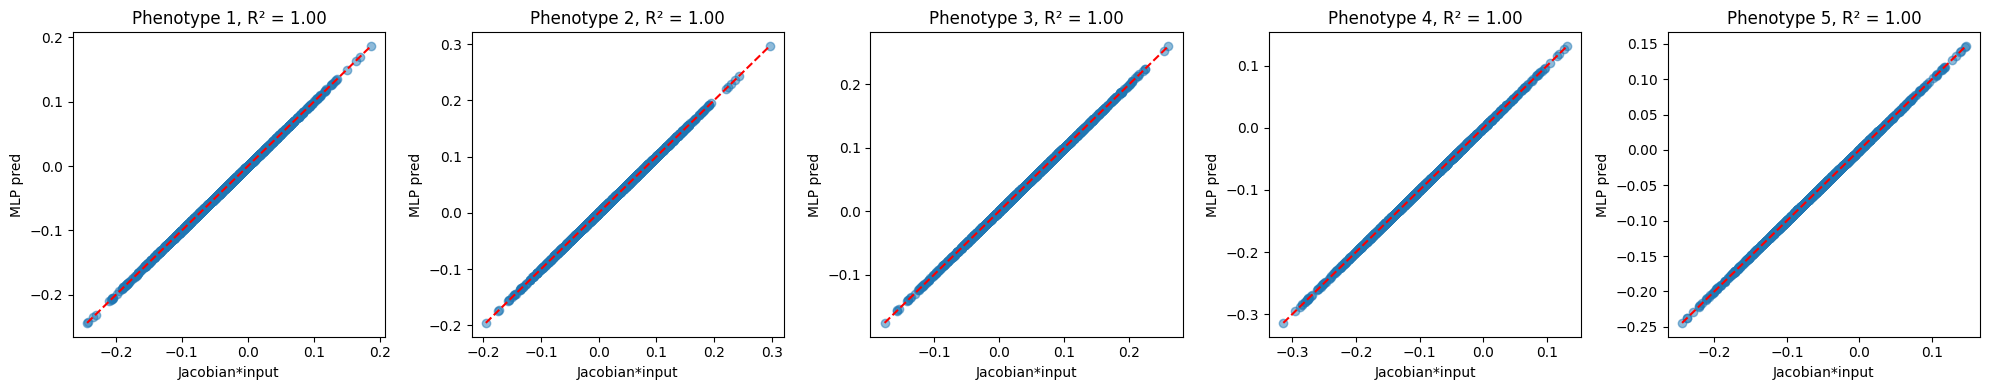

In [168]:
dot_products, predictions = plot_jacobian_vs_predictions(detached_model, test_loader_gp)

### linear locus sensitivity based on detached jacobian

First generate sensitivity value for each locus, for each phenotype, for each test set sample

In [169]:
# | code-fold: true

def analyze_feature_importance_across_validation(model, validation_loader, true_effects_df,
                                                phenotype_idx=[0], device=device, max_samples=None):
    """
    Calculate feature importance for each sample in the validation set and visualize distributions.

    Args:
        model: Trained neural network model
        validation_loader: DataLoader for validation data
        true_effects_df: DataFrame containing ground truth effects
        phenotype_idx: List of indexes of phenotypes to analyze (default: [0] for first phenotype)
        device: Device to run calculations on
        max_samples: Maximum number of samples to process (None for all)

    Returns:
        List of DataFrames with importance values for each locus across all samples, one per phenotype
    """
    # Convert single index to list for consistency
    if isinstance(phenotype_idx, int):
        phenotype_idx = [phenotype_idx]

    # Create detached version of model for Jacobian calculation
    detached_model = GP_net(
    n_loci=n_loci,
    hidden_layer_size=hidden_size,
    n_pheno=n_phen,
    detach_gate=True
    )

    # Copy weights from trained model
    detached_model.load_state_dict(model.state_dict())
    detached_model = detached_model.to(device)

    # Function to get importance for a specific phenotype
    def get_phenotype_importance(x, pheno_idx):
        def phenotype_fn(inp):
            return detached_model(inp)[:, pheno_idx]

        # Calculate Jacobian
        jacobian = torch.autograd.functional.jacobian(
            phenotype_fn,
            x,
            vectorize=True
        ).squeeze()

        # Return unmodified Jacobian value
        return jacobian

    # Store importance values for each sample and each phenotype
    all_importance_values = {idx: [] for idx in phenotype_idx}
    sample_count = 0

    # Process validation samples
    with torch.no_grad():  # No need for gradients in the forward pass
        for phens, gens in validation_loader:
            # Process each sample in the batch
            for i in range(gens.shape[0]):
                # Check if we've reached the maximum samples
                if max_samples is not None and sample_count >= max_samples:
                    break

                # Get single sample
                single_gens = gens[i:i+1]

                # Flatten and simplify (remove one-hot encoding)
                flattened_gens = single_gens.reshape(single_gens.shape[0], -1)
                simplified_gens = flattened_gens[:, 1::2].to(device)

                # Calculate importance for each phenotype
                for idx in phenotype_idx:
                    importance = get_phenotype_importance(simplified_gens, idx)
                    # Store the importance values
                    all_importance_values[idx].append(importance.cpu().numpy())

                sample_count += 1

                # Print progress
                if sample_count % 1000 == 0:
                    print(f"Processed {sample_count} samples")

            # Check again after batch
            if max_samples is not None and sample_count >= max_samples:
                break

    print(f"Completed importance analysis for {sample_count} samples")

    # Convert to DataFrames for easier analysis
    importance_dfs = {}
    for idx in phenotype_idx:
        importance_df = pd.DataFrame(all_importance_values[idx])
        importance_df.columns = [f'Locus_{i}' for i in range(importance_df.shape[1])]
        importance_dfs[idx] = importance_df

    # Create boxplot visualization
    plt.figure(figsize=(len(phenotype_idx) * 15, 7))

    # Create subplots for scatter plots
    fig2, axes2 = plt.subplots(1, len(phenotype_idx), figsize=(len(phenotype_idx) * 5, 5))
    if len(phenotype_idx) == 1:
        axes2 = [axes2]  # Convert to list for consistent indexing

    for i, idx in enumerate(phenotype_idx):
        # Get the dataframe for this phenotype
        importance_df = importance_dfs[idx]

        # Extract ground truth for the specific phenotype
        true_effects = true_effects_df[true_effects_df['trait'] == idx + 1]

        # Generate correlation plot between median importance and true effects
        if 'add_eff' in true_effects.columns:
            # Get data for scatter plot
            true_effects_values = true_effects['add_eff'] * np.sqrt(heritability)
            mean_importance = importance_df.mean().values

            # Create scatter plot
            axes2[i].scatter(true_effects_values, mean_importance, alpha=0.7)

            # Add best fit line
            z = np.polyfit(true_effects_values, mean_importance, 1)
            p = np.poly1d(z)
            axes2[i].plot(true_effects_values, p(true_effects_values), "r--", alpha=0.7)

            # Add correlation coefficient
            corr = np.corrcoef(true_effects_values, mean_importance)[0, 1]
            axes2[i].set_xlabel('Add effect size', fontsize=12)
            axes2[i].set_ylabel('Mean Locus Sensitivity', fontsize=12)
            axes2[i].set_title(f'Phenotype {idx+1}: r = {corr:.3f}')
            # Add this after the correlation coefficient calculation
            slope = z[0]  # Extract the slope from the polyfit result
            axes2[i].text(0.05, 0.95, f'Slope = {slope:.3f}',
                        transform=axes2[i].transAxes,
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    fig2.tight_layout()

    # Show both sets of plots
    plt.show()

    # Return the DataFrames for further analysis
    return list(importance_dfs.values())

Visualize variance in locus sensitity for each locus between individuals


Visualize concordance between mean sensitivity and true additive effect size

Processed 1000 samples
Completed importance analysis for 1500 samples


<Figure size 7500x700 with 0 Axes>

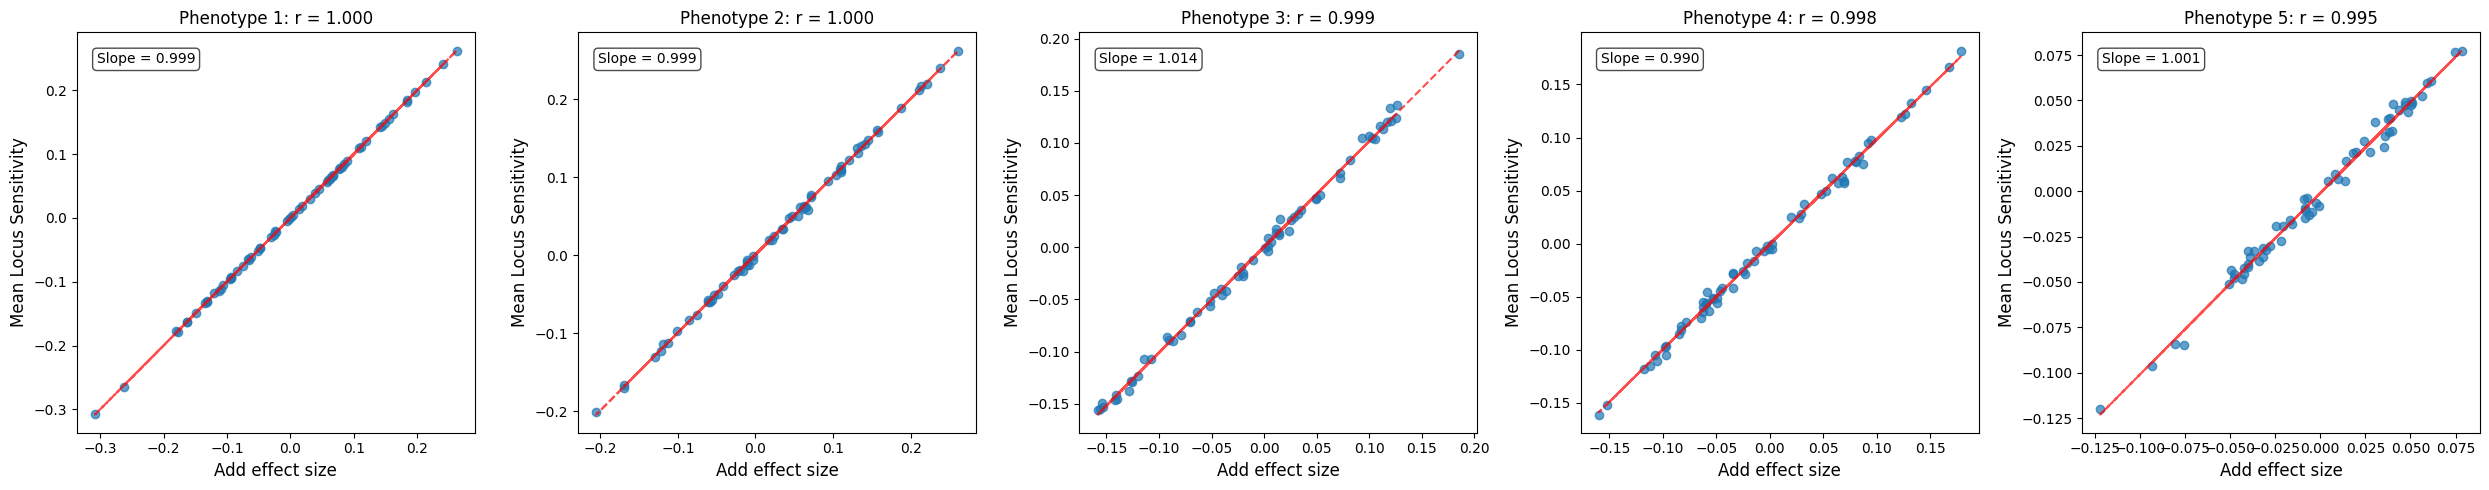

In [170]:
# Usage example:
importance_results = analyze_feature_importance_across_validation(
    model=model,
    validation_loader=test_loader_gp,
    true_effects_df=true_eff,
    phenotype_idx=[0,1,2,3,4],  #  phenotype
    device=device,
    max_samples=2000  # Limit number of samples for faster processing
)

Notice that the variance in sensitivity is directly a product of epistasis. 

Loci that are involved in epistatic interactions vary in their contribution to phenotype between samples as their effects are context dependent.

In [171]:
# | code-fold: true

def plot_sensitivity_variance_vs_epistasis(importance_dfs, true_effects_df, phenotype_idx=[0]):
    """
    Plot the variance in locus sensitivity across samples versus epistatic effects,
    with a quadratic fit curve and equation.

    Args:
        importance_dfs: List of DataFrames with importance values, one per phenotype
        true_effects_df: DataFrame containing ground truth effects
        phenotype_idx: List of indexes of phenotypes to analyze (default: [0] for first phenotype)

    Returns:
        None
    """
    # Convert single index to list for consistency
    if isinstance(phenotype_idx, int):
        phenotype_idx = [phenotype_idx]

    # Create subplots
    fig, axes = plt.subplots(1, len(phenotype_idx), figsize=(len(phenotype_idx) * 4, 4))
    if len(phenotype_idx) == 1:
        axes = [axes]  # Convert to list for consistent indexing

    for i, idx in enumerate(phenotype_idx):
        # Get the dataframe for this phenotype
        if isinstance(importance_dfs, list):
            importance_df = importance_dfs[i]
        else:
            importance_df = importance_dfs[idx]

        # Calculate variance for each locus
        locus_variance = importance_df.var().values

        # Extract ground truth for the specific phenotype
        true_effects = true_effects_df[true_effects_df['trait'] == idx + 1]

        # Extract epistatic effects
        epistatic_effects = true_effects['epi_eff'].values
        epistatic_effects = epistatic_effects * np.sqrt(heritability)

        # Create scatter plot
        axes[i].scatter(epistatic_effects, locus_variance, alpha=0.7, color='blue',
                       label='Data points')

        # Fit quadratic curve (y = ax² + bx + c)
        if len(epistatic_effects) > 2:  # Need at least 3 points for quadratic fit
            from numpy.polynomial.polynomial import polyfit

            # Polynomial fit (degree 2 for quadratic)
            c, b, a = polyfit(epistatic_effects, locus_variance, 2)

            # Generate points for the fit curve
            x_fit = np.linspace(min(epistatic_effects), max(epistatic_effects), 100)
            y_fit = a * x_fit**2 + b * x_fit + c

            # Plot the fit curve
            axes[i].plot(x_fit, y_fit, 'r-', linewidth=2, label='Quadratic fit')

            # Add the equation to the plot
            equation = f'y = {a:.4f}x² + ...'

            # Calculate R-squared
            y_pred = a * np.array(epistatic_effects)**2 + b * np.array(epistatic_effects) + c
            ss_total = np.sum((locus_variance - np.mean(locus_variance))**2)
            ss_residual = np.sum((locus_variance - y_pred)**2)
            r_squared = 1 - (ss_residual / ss_total)

            # Add equation and R² to the plot
            axes[i].text(0.05, 0.95, f'{equation}\nR² = {r_squared:.4f}',
                        transform=axes[i].transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

        # Add labels and title
        axes[i].set_xlabel('Epistatic Effect Size', fontsize=12)
        axes[i].set_ylabel('Locus Sensitivity Variance', fontsize=12)
        axes[i].set_title(f'Phenotype {idx+1}', fontsize=14)

        # Add legend
        if len(epistatic_effects) > 2:
            axes[i].legend()

    # Standardize y-axis limits across all subplots
    y_min = min([ax.get_ylim()[0] for ax in axes])
    y_max = max([ax.get_ylim()[1] for ax in axes])
    for ax in axes:
        ax.set_ylim([y_min, y_max])

    # Adjust layout
    fig.tight_layout()
    fig.suptitle('Relationship Between Epistatic Effect Size and Variance in Locus Sensitivity',
                fontsize=16, y=1.05)
    plt.show()


We can demonstrate this by plotting locus sensitivity variance (among individuals) vs. the epistatic effect size of the locus. A quadratic relationship emerges due to the y axis plotting a variance term. 

/Users/georgy/miniconda3/envs/gpmap/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


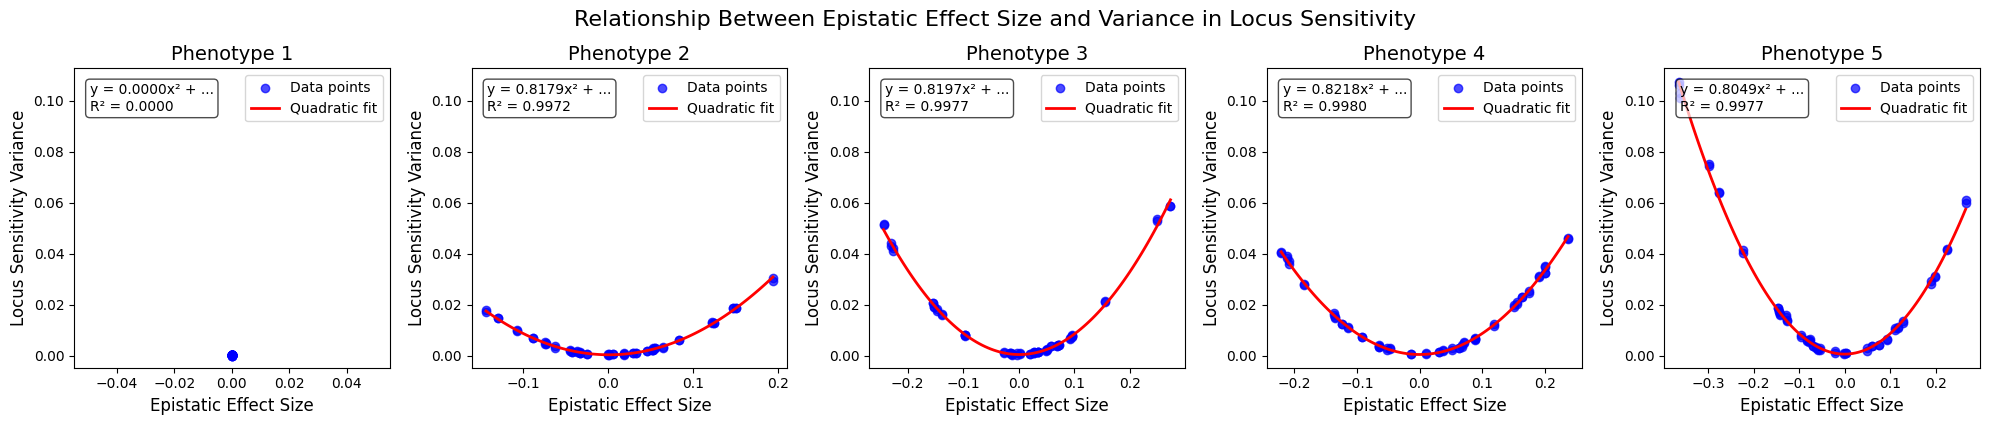

In [172]:
plot_sensitivity_variance_vs_epistasis(importance_results, true_eff, phenotype_idx=[0, 1, 2, 3 ,4])

We can also hunt for epistatic couplings by calculating the covariance in sensitivity values across pairs of loci. 

Pairwise interactors should show some signal of covariation in sensitivity (as they affect each other when found together). 


Finally we can test how much the Jacobian vectors vary from sample to sample to check just how 'local' the reconstruction is. As expected, for additive phenotypes, the reconstruction turns out to be quite global, with most samples having near identical Jacobian vectors. 

In [173]:
# | code-fold: true

def extract_top_epistatic_pairs(model, validation_loader, true_effects_df,
                               top_n=10, phenotype_idx=None, device='cuda',
                               max_samples=1000, plot_summary=True,
                               selection_type='top', genotype_encoding=(-1, 1)):
    """
    Extract the top or bottom N strongest epistatic pairs for each phenotype, along with
    their raw sensitivity values and combined genotypes. Only includes unique
    locus combinations (eliminates duplicates like locus1/locus2 and locus2/locus1).

    Returns a dictionary of detailed results and a summarized DataFrame with one row
    per phenotype/genotype/locus pair, with separate columns for genotype1 and genotype2.

    Args:
        model: Trained neural network model
        validation_loader: DataLoader for validation data
        true_effects_df: DataFrame containing ground truth effects (must have epi_eff column)
        top_n: Number of top/bottom epistatic pairs to extract per phenotype
        phenotype_idx: List of phenotype indices to analyze (None for all phenotypes)
        device: Device to run calculations on
        max_samples: Maximum number of samples to process
        plot_summary: Whether to plot summary visualizations
        selection_type: 'top' to select largest magnitude epistatic effects, 'bottom' for smallest
        genotype_encoding: Tuple of (low, high) values used for encoding genotypes (default: (-1, 1))

    Returns:
        tuple: (results_dict, summary_df)
            - results_dict: Dictionary with detailed results
            - summary_df: DataFrame with one row per phenotype/genotype/locus pair
    """
    # Validate selection_type
    if selection_type not in ['top', 'bottom']:
        raise ValueError("selection_type must be either 'top' or 'bottom'")

    # Extract genotype encoding values
    low_encoding, high_encoding = genotype_encoding

    # Function to convert between -1/1 and 0/1 encoding (for display purposes)
    def to_binary_encoding(genotype):
        if genotype == low_encoding:
            return 0
        elif genotype == high_encoding:
            return 1
        else:
            raise ValueError(f"Unexpected genotype value: {genotype}")

    # Ensure true_effects_df has required columns
    required_cols = ['trait', 'locus', 'epi_loc', 'epi_eff']
    if not all(col in true_effects_df.columns for col in required_cols):
        raise ValueError(f"true_effects_df must have these columns: {required_cols}")

    # Check for additive effects columns
    if 'add_eff' in true_effects_df.columns:
        add_eff_col = 'add_eff'

    # Determine phenotype indices to analyze
    if phenotype_idx is None:
        # Get all unique phenotypes from true_effects_df
        all_traits = true_effects_df['trait'].unique()
        # Convert to 0-based indexing if needed
        phenotype_idx = [int(trait) - 1 if trait >= 1 else int(trait) for trait in all_traits]
    elif isinstance(phenotype_idx, int):
        phenotype_idx = [phenotype_idx]

    print(f"Analyzing phenotypes: {[idx+1 for idx in phenotype_idx]}")
    print(f"Selection type: {selection_type} {top_n} epistatic pairs")
    print(f"Genotype encoding: {genotype_encoding}")

    # Create detached version of model for Jacobian calculation (copied from your function)
    detached_model = GP_net(
        n_loci=n_loci,
        hidden_layer_size=hidden_size,
        n_pheno=n_phen,
        detach_gate=True
        )

    detached_model.load_state_dict(model.state_dict())
    detached_model = detached_model.to(device)


    # Function to get importance for a specific phenotype (copied from your function)
    def get_phenotype_importance(x, pheno_idx):
        def phenotype_fn(inp):
            return detached_model(inp)[:, pheno_idx]

        # Calculate Jacobian
        jacobian = torch.autograd.functional.jacobian(
            phenotype_fn,
            x,
            vectorize=True
        ).squeeze()

        # Return unmodified Jacobian value
        return jacobian

    # Find top/bottom N epistatic pairs for each phenotype
# Find top/bottom N epistatic pairs for each phenotype
    top_pairs = {}
    for idx in phenotype_idx:
        # Filter true effects for this phenotype
        trait_idx = idx + 1  # Convert 0-based to 1-based indexing
        pheno_effects = true_effects_df[true_effects_df['trait'] == trait_idx]

        # Get non-zero effects (avoid selecting pairs with no epistasis)
        pheno_effects = pheno_effects[pheno_effects['epi_eff'] != 0]

        # Calculate absolute epistatic effect
        pheno_effects['abs_epi_eff'] = np.abs(pheno_effects['epi_eff'])

        # Sort by absolute epistatic effect
        if selection_type == 'top':
            # Largest absolute effects first (descending)
            sorted_effects = pheno_effects.sort_values('abs_epi_eff', ascending=False)
        else:  # 'bottom'
            # Smallest absolute effects first (ascending)
            sorted_effects = pheno_effects.sort_values('abs_epi_eff', ascending=True)

        # Create set to track unique locus pairs
        unique_pairs = set()
        pairs = []

        # Process pairs in sorted order
        for _, row in sorted_effects.iterrows():
            # Convert to 0-based indexing if needed
            locus1 = int(row['locus']) - 1 if row['locus'] >= 1 else int(row['locus'])
            locus2 = int(row['epi_loc']) - 1 if row['epi_loc'] >= 1 else int(row['epi_loc'])

            # Create a canonical representation of the pair (always smaller locus first)
            # This ensures we don't count both (a,b) and (b,a) as separate pairs
            pair_key = tuple(sorted([locus1, locus2]))

            # Skip if we've already seen this pair
            if pair_key in unique_pairs:
                continue

            # Add to set of unique pairs
            unique_pairs.add(pair_key)

            # Get additive effects
            if add_eff_col is not None:
                # Get additive effect for locus1
                add_eff1 = row[add_eff_col]

                # Get additive effect for locus2 (might need to find it in another row)
                if 'add_eff2' in row and not pd.isna(row['add_eff2']):
                    add_eff2 = row['add_eff2']
                else:
                    # Try to find locus2's additive effect in another row
                    locus2_row = pheno_effects[pheno_effects['locus'] == row['epi_loc']]
                    if len(locus2_row) > 0:
                        add_eff2 = locus2_row.iloc[0][add_eff_col]
                    else:
                        add_eff2 = None
            else:
                add_eff1 = None
                add_eff2 = None

            # Store pair info
            pairs.append({
                'locus1': locus1,
                'locus2': locus2,
                'epi_eff': row['epi_eff'],
                'abs_epi_eff': row['abs_epi_eff'],
                'add_eff1': add_eff1,
                'add_eff2': add_eff2
            })

            # Break once we have top_n unique pairs
            if len(pairs) >= top_n:
                break

        top_pairs[idx] = pairs
        print(f"Selected {len(pairs)} unique {selection_type} epistatic pairs for phenotype {idx+1}")

        # Print magnitude range
        if len(pairs) > 0:
            min_mag = min(pair['abs_epi_eff'] for pair in pairs)
            max_mag = max(pair['abs_epi_eff'] for pair in pairs)
            print(f"  Epistatic effect magnitude range: {min_mag:.6f} to {max_mag:.6f}")


    # Process validation samples to get sensitivities and genotypes
    results = {}
    sample_indices = []
    genotypes_dict = {}
    sensitivities_dict = defaultdict(lambda: defaultdict(list))

    # Process validation samples
    sample_count = 0
    with torch.no_grad():  # No need for gradients in the forward pass
        for batch_idx, (phens, gens) in enumerate(validation_loader):
            # Process each sample in the batch
            for i in range(gens.shape[0]):
                # Check if we've reached the maximum samples
                if max_samples is not None and sample_count >= max_samples:
                    break

                # Store sample index
                sample_indices.append(sample_count)

                # Get single sample
                single_gens = gens[i:i+1]

                # Flatten and simplify (remove one-hot encoding)
                flattened_gens = single_gens.reshape(single_gens.shape[0], -1)
                simplified_gens = flattened_gens[:, 1::2].to(device)

                # Store the raw genotype data
                genotype = simplified_gens.cpu().numpy().squeeze()
                genotypes_dict[sample_count] = genotype

                # Calculate importance for each phenotype
                for idx in phenotype_idx:
                    importance = get_phenotype_importance(simplified_gens, idx)
                    importance_np = importance.cpu().numpy()

                    # Store sensitivity values for each locus in top pairs
                    for pair in top_pairs[idx]:
                        locus1 = pair['locus1']
                        locus2 = pair['locus2']
                        pair_key = (idx, locus1, locus2)

                        # Store sensitivity values
                        sensitivities_dict[pair_key]['locus1'].append(importance_np[locus1])
                        sensitivities_dict[pair_key]['locus2'].append(importance_np[locus2])

                sample_count += 1

                # Print progress
                if sample_count % 1000 == 0:
                    print(f"Processed {sample_count} samples")

            # Check again after batch
            if max_samples is not None and sample_count >= max_samples:
                break

    print(f"Completed analysis for {sample_count} samples")

    # Prepare final results
    results = {}
    summary_rows = []  # For the summarized DataFrame

    # Get phenotype names (trait names) if available
    trait_names = {}
    if 'trait_name' in true_effects_df.columns:
        for _, row in true_effects_df.drop_duplicates('trait').iterrows():
            trait_names[row['trait'] - 1] = row['trait_name']  # Convert to 0-based index

    for idx in phenotype_idx:
        # Get phenotype name if available, otherwise use index
        phenotype_name = trait_names.get(idx, f"Phenotype_{idx+1}")

        for pair in top_pairs[idx]:
            locus1 = pair['locus1']
            locus2 = pair['locus2']
            pair_key = (idx, locus1, locus2)

            # Get sensitivity values
            locus1_sensitivities = np.array(sensitivities_dict[pair_key]['locus1'])
            locus2_sensitivities = np.array(sensitivities_dict[pair_key]['locus2'])

            # Get genotypes for this pair
            genotype1_values = []
            genotype2_values = []
            combined_genotypes = []

            for s_idx in sample_indices:
                genotype = genotypes_dict[s_idx]

                # Extract genotype values for the two loci
                geno1 = genotype[locus1]
                geno2 = genotype[locus2]

                # Store individual genotypes
                genotype1_values.append(geno1)
                genotype2_values.append(geno2)

                # Encode combined genotype - modified for -1/1 encoding
                # For display purposes we convert to 0/1 encoding (00, 01, 10, 11)
                # The combined value will be: 0 (low,low), 1 (low,high), 2 (high,low), 3 (high,high)
                binary_geno1 = 1 if geno1 == high_encoding else 0
                binary_geno2 = 1 if geno2 == high_encoding else 0
                combined = binary_geno1 * 2 + binary_geno2
                combined_genotypes.append(combined)

            # Convert to numpy arrays
            genotype1_values = np.array(genotype1_values)
            genotype2_values = np.array(genotype2_values)
            combined_genotypes = np.array(combined_genotypes)

            # Store detailed results
            results[pair_key] = {
                'locus1_sensitivities': locus1_sensitivities,
                'locus2_sensitivities': locus2_sensitivities,
                'genotype1_values': genotype1_values,
                'genotype2_values': genotype2_values,
                'combined_genotypes': combined_genotypes,
                'add_eff1': pair['add_eff1'],
                'add_eff2': pair['add_eff2'],
                'epi_eff': pair['epi_eff'],
                'abs_epi_eff': pair['abs_epi_eff'],
                'samples': np.array(sample_indices)
            }

            # Calculate mean sensitivity values for each genotype combination
            # We use the actual encoding values, not 0/1
            for geno1 in [low_encoding, high_encoding]:
                for geno2 in [low_encoding, high_encoding]:
                    # Create mask for this genotype combination
                    mask = (genotype1_values == geno1) & (genotype2_values == geno2)

                    if np.any(mask):
                        # Get mean sensitivities for this genotype combination
                        mean_sens1 = np.mean(locus1_sensitivities[mask])
                        mean_sens2 = np.mean(locus2_sensitivities[mask])
                        count = np.sum(mask)

                        # Create a row for the summary DataFrame
                        summary_rows.append({
                            'phenotype': phenotype_name,
                            'phenotype_idx': idx,
                            'locus1': locus1,
                            'locus2': locus2,
                            'genotype1': binary_geno1,  # Store as 0/1 for consistency
                            'genotype2': binary_geno2,  # Store as 0/1 for consistency
                            'raw_genotype1': geno1,     # Store actual -1/1 values
                            'raw_genotype2': geno2,     # Store actual -1/1 values
                            'add_eff1': pair['add_eff1'],
                            'add_eff2': pair['add_eff2'],
                            'epi_eff': pair['epi_eff'],
                            'abs_epi_eff': pair['abs_epi_eff'],
                            'mean_sens1': mean_sens1,
                            'mean_sens2': mean_sens2,
                            'count': count,
                            'selection_type': selection_type
                        })

    # Create the summary DataFrame
    summary_df = pd.DataFrame(summary_rows)

    # Add some useful calculated columns
    if len(summary_df) > 0:
        # Calculate covariance between locus1 and locus2 sensitivities for each pair
        for idx in phenotype_idx:
            for pair in top_pairs[idx]:
                locus1 = pair['locus1']
                locus2 = pair['locus2']
                pair_key = (idx, locus1, locus2)

                # Get sensitivities and genotypes
                sens1 = results[pair_key]['locus1_sensitivities']
                sens2 = results[pair_key]['locus2_sensitivities']

                # Update all rows for this pair
                mask = (summary_df['phenotype_idx'] == idx) & (summary_df['locus1'] == locus1) & (summary_df['locus2'] == locus2)


        # Add combined genotype column for convenience
        summary_df['genotype_combined'] = summary_df['genotype1'].astype(str) + summary_df['genotype2'].astype(str)

    # Plot summary visualizations if requested
    if plot_summary and results:
        # Calculate max number of pairs across all phenotypes
        max_pairs = max(len(pairs) for pairs in top_pairs.values())
        num_cols = min(top_n, max_pairs)

        # Skip plotting if no pairs were found
        if num_cols == 0:
            print("No pairs to plot.")
            return results, summary_df

        # Create figure with subplots for each phenotype
        fig, axes = plt.subplots(len(phenotype_idx), num_cols,
                                figsize=(4*num_cols, 4*len(phenotype_idx)),
                                squeeze=False)

        # For each phenotype
        for i, idx in enumerate(phenotype_idx):
            # For each pair
            for j, pair in enumerate(top_pairs[idx]):
                locus1 = pair['locus1']
                locus2 = pair['locus2']
                pair_key = (idx, locus1, locus2)

                # Skip if pair not in results
                if pair_key not in results:
                    continue

                # Get data
                pair_data = results[pair_key]
                locus1_sens = pair_data['locus1_sensitivities']
                locus2_sens = pair_data['locus2_sensitivities']
                combined_geno = pair_data['combined_genotypes']

                # Create scatter plot
                ax = axes[i, j]

                # Create scatter plot with different colors for each genotype combination
                # We use low/high terminology for labels to be encoding-agnostic
                genotype_labels = [f'{low_encoding}/{low_encoding}',
                                  f'{low_encoding}/{high_encoding}',
                                  f'{high_encoding}/{low_encoding}',
                                  f'{high_encoding}/{high_encoding}']
                colors = ['blue', 'green', 'orange', 'red']

                for geno in range(4):
                    mask = combined_geno == geno
                    if np.any(mask):
                        ax.scatter(
                            locus1_sens[mask],
                            locus2_sens[mask],
                            c=colors[geno],
                            label=genotype_labels[geno],
                            alpha=0.7
                        )

                # Add labels and title
                ax.set_xlabel(f'Locus {locus1} Sensitivity')
                ax.set_ylabel(f'Locus {locus2} Sensitivity')
                epi_mag = pair['abs_epi_eff']
                title = f'Phenotype {idx+1}: Loci {locus1}/{locus2}\nEpi Effect: {pair["epi_eff"]:.10f}'
                ax.set_title(title)

                # Add legend
                ax.legend(title="Genotypes")

                # Add grid
                ax.grid(True, alpha=0.3)

        # Add title indicating selection type
        selection_title = f"{selection_type.capitalize()} {top_n} Epistatic Pairs by Magnitude"
        fig.suptitle(selection_title, fontsize=16, y=1.02)

        plt.tight_layout()
        plt.show()

    return results, summary_df

Analyzing phenotypes: [2]
Selection type: top 5 epistatic pairs
Genotype encoding: (-1, 1)
Selected 5 unique top epistatic pairs for phenotype 2
  Epistatic effect magnitude range: 0.128982 to 0.194231
Processed 1000 samples
Completed analysis for 1500 samples


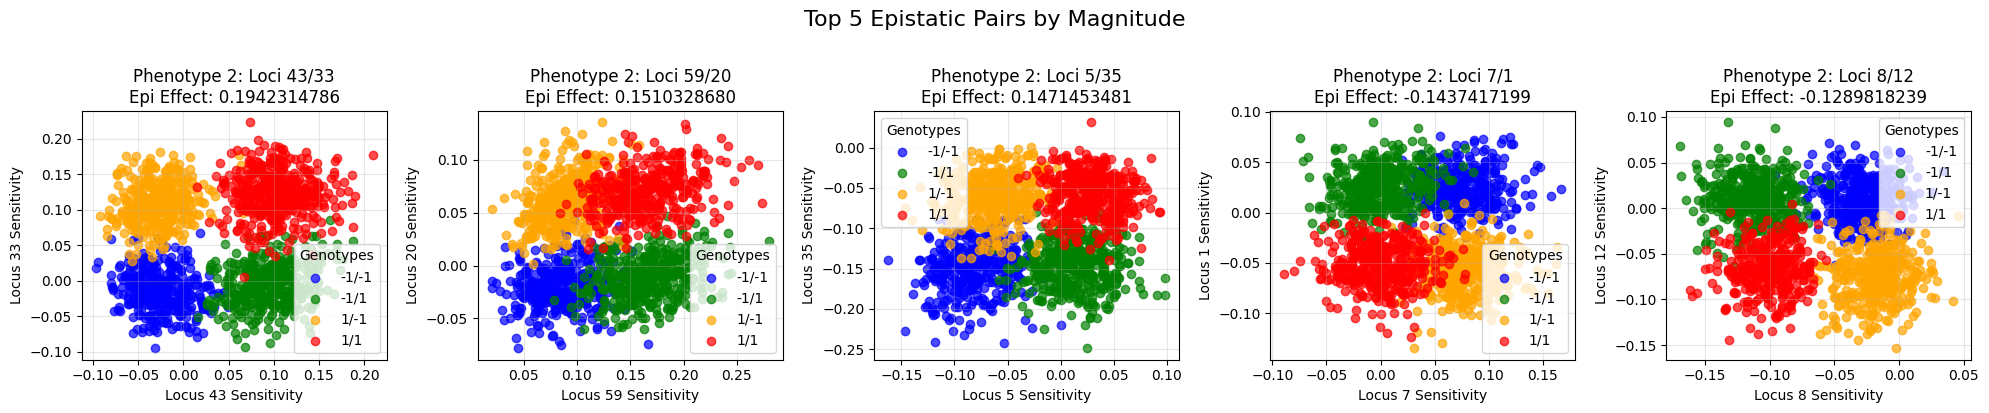

In [237]:
epi_jacobian, epi_summ = extract_top_epistatic_pairs(model, test_loader_gp, true_eff,
                               top_n=5, phenotype_idx=[1], device=device,
                               max_samples=2000, plot_summary=True, selection_type = 'top')


Estimate epistatic effects for all possible pairs of loci by looking at values of specific genotype combinations

In [175]:
# | code-fold: true

def extract_all_epistatic_pairs(model, validation_loader, true_effects_df,
                               phenotype_idx=None, device=device,
                               max_samples=1000):
    """
    Extract sensitivities for all possible unique pairs of loci for each phenotype.
    For pairs with known epistatic effects in true_effects_df, include those effects.
    For pairs without known epistatic effects, set the effect to 0.

    Uses 1-based locus indexing throughout.

    Args:
        model: Trained neural network model
        validation_loader: DataLoader for validation data
        true_effects_df: DataFrame containing ground truth effects with columns:
                         trait (1-based phenotype), locus (1-based), add_eff,
                         epi_loc (1-based interacting locus), epi_eff
        phenotype_idx: List of phenotype indices to analyze (None for all phenotypes)
        device: Device to run calculations on
        max_samples: Maximum number of samples to process

    Returns:
        DataFrame with one row per phenotype/genotype/locus pair
    """
    # Ensure true_effects_df has required columns
    required_cols = ['trait', 'locus', 'epi_loc', 'epi_eff']
    if not all(col in true_effects_df.columns for col in required_cols):
        raise ValueError(f"true_effects_df must have these columns: {required_cols}")

    # Check for additive effects columns
    if 'add_eff' in true_effects_df.columns:
        add_eff_col = 'add_eff'

    # Determine phenotype indices to analyze
    if phenotype_idx is None:
        # Get all unique phenotypes from true_effects_df
        all_traits = true_effects_df['trait'].unique()
        # Use 1-based indexing for phenotypes
        phenotype_idx = list(all_traits)
    elif isinstance(phenotype_idx, int):
        phenotype_idx = [phenotype_idx]

    print(f"Analyzing phenotypes: {phenotype_idx}")

    # Create detached version of model for Jacobian calculation
    detached_model = GP_net(
        n_loci=n_loci,
        hidden_layer_size=hidden_size,
        n_pheno=n_phen,
        detach_gate=True
        )

    detached_model.load_state_dict(model.state_dict())
    detached_model = detached_model.to(device)

    # Function to get importance for a specific phenotype
    def get_phenotype_importance(x, pheno_idx):
        # Adjust for 1-based phenotype indexing
        model_pheno_idx = pheno_idx - 1  # Convert 1-based to 0-based for the model

        def phenotype_fn(inp):
            return detached_model(inp)[:, model_pheno_idx]

        # Calculate Jacobian
        jacobian = torch.autograd.functional.jacobian(
            phenotype_fn,
            x,
            vectorize=True
        ).squeeze()

        # Return unmodified Jacobian value
        return jacobian

    # Get number of loci from the model
    n_loci_model = n_loci  # This should be defined in your environment or passed to the function

    # Create mapping of known epistatic effects
    epistatic_effects = {}
    additive_effects = {}

    # First, collect all additive effects
    for idx in phenotype_idx:
        additive_effects[idx] = {}
        pheno_effects = true_effects_df[true_effects_df['trait'] == idx]

        if add_eff_col is not None:
            # Get unique loci and their additive effects
            for _, row in pheno_effects.drop_duplicates('locus').iterrows():
                locus = int(row['locus'])
                add_eff = row[add_eff_col]
                additive_effects[idx][locus] = add_eff

    # Now collect all epistatic effects
    for idx in phenotype_idx:
        epistatic_effects[idx] = {}
        pheno_effects = true_effects_df[true_effects_df['trait'] == idx]

        # Process each row to extract epistatic effects
        for _, row in pheno_effects.iterrows():
            locus1 = int(row['locus'])
            locus2 = int(row['epi_loc'])

            # Create a canonical representation of the pair (smaller locus first)
            pair_key = tuple(sorted([locus1, locus2]))

            # Store the epistatic effect
            epistatic_effects[idx][pair_key] = row['epi_eff']

    # Generate all possible locus pairs
    all_pairs = {}
    for idx in phenotype_idx:
        pairs = []

        # Generate all possible pairs of loci (using 1-based indexing)
        for locus1 in range(1, n_loci_model + 1):  # Start from 1, not 0
            for locus2 in range(locus1 + 1, n_loci_model + 1):  # Only use each pair once
                # Create canonical pair key
                pair_key = (locus1, locus2)

                # Get epistatic effect if it exists, otherwise use 0
                epi_eff = epistatic_effects[idx].get(pair_key, 0.0)
                abs_epi_eff = abs(epi_eff)

                # Get additive effects
                add_eff1 = additive_effects[idx].get(locus1, 0.0)
                add_eff2 = additive_effects[idx].get(locus2, 0.0)

                # Store pair info
                pairs.append({
                    'locus1': locus1,
                    'locus2': locus2,
                    'epi_eff': epi_eff,
                    'abs_epi_eff': abs_epi_eff,
                    'add_eff1': add_eff1,
                    'add_eff2': add_eff2,
                    'has_epistasis': epi_eff != 0.0
                })

        all_pairs[idx] = pairs
        epistatic_count = sum(1 for p in pairs if p['has_epistasis'])
        print(f"Generated {len(pairs)} total locus pairs for phenotype {idx}, {epistatic_count} with known epistatic effects")

    # Process validation samples to get sensitivities and genotypes
    sample_indices = []
    genotypes_dict = {}
    sensitivities_dict = defaultdict(lambda: defaultdict(list))

    # Process validation samples
    sample_count = 0
    with torch.no_grad():
        for batch_idx, (phens, gens) in enumerate(validation_loader):
            # Process each sample in the batch
            for i in range(gens.shape[0]):
                # Check if we've reached the maximum samples
                if max_samples is not None and sample_count >= max_samples:
                    break

                # Store sample index
                sample_indices.append(sample_count)

                # Get single sample
                single_gens = gens[i:i+1]

                # Flatten and simplify (remove one-hot encoding)
                flattened_gens = single_gens.reshape(single_gens.shape[0], -1)
                simplified_gens = flattened_gens[:, 1::2].to(device)

                # Store the raw genotype data
                genotype = simplified_gens.cpu().numpy().squeeze()
                genotypes_dict[sample_count] = genotype

                # Calculate importance for each phenotype
                for idx in phenotype_idx:
                    importance = get_phenotype_importance(simplified_gens, idx)
                    importance_np = importance.cpu().numpy()

                    # Store sensitivity values for each locus in all pairs
                    for pair in all_pairs[idx]:
                        locus1 = pair['locus1']
                        locus2 = pair['locus2']
                        pair_key = (idx, locus1, locus2)

                        # Convert from 1-based to 0-based for accessing the importance array
                        model_locus1 = locus1 - 1
                        model_locus2 = locus2 - 1

                        # Store sensitivity values
                        sensitivities_dict[pair_key]['locus1'].append(importance_np[model_locus1])
                        sensitivities_dict[pair_key]['locus2'].append(importance_np[model_locus2])

                sample_count += 1

                # Print progress
                if sample_count % 1000 == 0:
                    print(f"Processed {sample_count} samples")

            # Check again after batch
            if max_samples is not None and sample_count >= max_samples:
                break

    print(f"Completed analysis for {sample_count} samples")

    # Prepare final results
    summary_rows = []  # For the summarized DataFrame

    # Get phenotype names (trait names) if available
    trait_names = {}
    if 'trait_name' in true_effects_df.columns:
        for _, row in true_effects_df.drop_duplicates('trait').iterrows():
            trait_names[row['trait']] = row['trait_name']  # Keep 1-based indexing

    for idx in phenotype_idx:
        # Get phenotype name if available, otherwise use index
        phenotype_name = trait_names.get(idx, f"Phenotype_{idx}")

        for pair in all_pairs[idx]:
            locus1 = pair['locus1']
            locus2 = pair['locus2']
            pair_key = (idx, locus1, locus2)

            # Get sensitivity values
            locus1_sensitivities = np.array(sensitivities_dict[pair_key]['locus1'])
            locus2_sensitivities = np.array(sensitivities_dict[pair_key]['locus2'])

            # Get genotypes for this pair
            genotype1_values = []
            genotype2_values = []
            combined_genotypes = []

            for s_idx in sample_indices:
                genotype = genotypes_dict[s_idx]

                # Convert from 1-based to 0-based for accessing genotype array
                model_locus1 = locus1 - 1
                model_locus2 = locus2 - 1

                # Extract genotype values for the two loci
                geno1 = genotype[model_locus1]
                geno2 = genotype[model_locus2]

                # Store individual genotypes
                genotype1_values.append(geno1)
                genotype2_values.append(geno2)

                # Encode combined genotype for -1/1 encoding
                # Map (-1,-1) → 0, (-1,1) → 1, (1,-1) → 2, (1,1) → 3
                combined = ((geno1 + 1) // 2) * 2 + ((geno2 + 1) // 2)
                combined_genotypes.append(combined)

            # Convert to numpy arrays
            genotype1_values = np.array(genotype1_values)
            genotype2_values = np.array(genotype2_values)
            combined_genotypes = np.array(combined_genotypes)

            # Calculate mean sensitivity values for each genotype combination
            for geno1 in [-1, 1]:
                for geno2 in [-1, 1]:
                    # Create mask for this genotype combination
                    mask = (genotype1_values == geno1) & (genotype2_values == geno2)

                    if np.any(mask):
                        # Get mean sensitivities for this genotype combination
                        mean_sens1 = np.mean(locus1_sensitivities[mask])
                        mean_sens2 = np.mean(locus2_sensitivities[mask])
                        count = np.sum(mask)

                        # Create a row for the summary DataFrame
                        summary_rows.append({
                            'phenotype': phenotype_name,
                            'phenotype_idx': idx,
                            'locus1': locus1,
                            'locus2': locus2,
                            'genotype1': geno1,
                            'genotype2': geno2,
                            'add_eff1': pair['add_eff1'],
                            'add_eff2': pair['add_eff2'],
                            'epi_eff': pair['epi_eff'],
                            'abs_epi_eff': pair['abs_epi_eff'],
                            'mean_sens1': mean_sens1,
                            'mean_sens2': mean_sens2,
                            'count': count,
                            'has_epistasis': pair['has_epistasis']
                        })

    # Create the summary DataFrame
    summary_df = pd.DataFrame(summary_rows)

    # Add some useful calculated columns
    if len(summary_df) > 0:
        # Calculate covariance between locus1 and locus2 sensitivities for each pair
        for idx in phenotype_idx:
            for pair in all_pairs[idx]:
                locus1 = pair['locus1']
                locus2 = pair['locus2']
                pair_key = (idx, locus1, locus2)

                if pair_key in sensitivities_dict:
                    # Get sensitivities
                    sens1 = np.array(sensitivities_dict[pair_key]['locus1'])
                    sens2 = np.array(sensitivities_dict[pair_key]['locus2'])

                    # Update all rows for this pair
                    mask = (summary_df['phenotype_idx'] == idx) & (summary_df['locus1'] == locus1) & (summary_df['locus2'] == locus2)

        # Add combined genotype column for convenience
        summary_df['genotype_combined'] = summary_df['genotype1'].astype(str) + summary_df['genotype2'].astype(str)

        # Calculate weighted means across genotypes
        # Create unique pair identifiers
        summary_df['pair_id'] = summary_df['phenotype_idx'].astype(str) + '_' + \
                               summary_df['locus1'].astype(str) + '_' + \
                               summary_df['locus2'].astype(str)

        # Add weighted mean sensitivities
        weighted_means = summary_df.groupby('pair_id').apply(
            lambda x: pd.Series({
                'weighted_mean_sens1': (x['mean_sens1'] * x['count']).sum() / x['count'].sum(),
                'weighted_mean_sens2': (x['mean_sens2'] * x['count']).sum() / x['count'].sum(),
                'total_samples': x['count'].sum()
            })
        )

        # Merge weighted means back to summary_df
        summary_df = summary_df.merge(weighted_means, on='pair_id')

    return summary_df

In [238]:
# | code-fold: true

def estimate_effects_from_sensitivities(summary_df, heritability=1.0):
    """
    Estimate additive and epistatic effects from locus sensitivity means across genotype combinations.
    Works with either 0/1 or -1/1 genotype encoding.
    Applies appropriate sign corrections and heritability scaling.

    Args:
        summary_df: DataFrame output from extract_top_epistatic_pairs or extract_all_epistatic_pairs,
                   containing mean sensitivity values for each locus/genotype combination
        heritability: The broad-sense heritability value used for the phenotype (default=1.0)

    Returns:
        DataFrame with estimated additive and epistatic effects for each locus pair,
        alongside true values for comparison
    """
    # Create unique identifier for each locus pair
    summary_df['pair_id'] = summary_df['phenotype_idx'].astype(str) + '_' + \
                           summary_df['locus1'].astype(str) + '_' + \
                           summary_df['locus2'].astype(str)

    # Calculate heritability scaling factor
    h_sqrt = np.sqrt(heritability)
    print(f"Using heritability scaling factor: {h_sqrt:.4f} (h² = {heritability:.2f})")

    # Determine genotype encoding by checking values in the dataframe
    unique_genotypes = set(summary_df['genotype1'].unique()) | set(summary_df['genotype2'].unique())
    if -1 in unique_genotypes:
        # Using -1/1 encoding
        encoding_type = "-1/1"
        genotype_mapping = {
            (-1, -1): "00",
            (-1, 1): "01",
            (1, -1): "10",
            (1, 1): "11"
        }
    else:
        # Using 0/1 encoding
        encoding_type = "0/1"
        genotype_mapping = {
            (0, 0): "00",
            (0, 1): "01",
            (1, 0): "10",
            (1, 1): "11"
        }

    print(f"Detected genotype encoding: {encoding_type}")

    # Initialize results list
    results = []

    # Process each unique locus pair
    for pair_id in summary_df['pair_id'].unique():
        # Get data for this pair
        pair_data = summary_df[summary_df['pair_id'] == pair_id].copy()

        # Extract true effects (same for all rows of this pair)
        true_add_eff1 = pair_data['add_eff1'].iloc[0]
        true_add_eff2 = pair_data['add_eff2'].iloc[0]
        true_epi_eff = pair_data['epi_eff'].iloc[0]
        phenotype = pair_data['phenotype'].iloc[0]
        phenotype_idx = pair_data['phenotype_idx'].iloc[0]
        locus1 = pair_data['locus1'].iloc[0]
        locus2 = pair_data['locus2'].iloc[0]

        # Apply heritability scaling to true effects
        scaled_true_add_eff1 = true_add_eff1 * h_sqrt if true_add_eff1 is not None else None
        scaled_true_add_eff2 = true_add_eff2 * h_sqrt if true_add_eff2 is not None else None
        scaled_true_epi_eff = true_epi_eff * h_sqrt if true_epi_eff is not None else None

        # Create dictionary to store sensitivity means by genotype
        sens1_by_genotype = {}
        sens2_by_genotype = {}

        # Fill dictionary with sensitivity means for each genotype combination
        for _, row in pair_data.iterrows():
            geno1 = row['genotype1']
            geno2 = row['genotype2']
            genotype_key = genotype_mapping.get((geno1, geno2), f"{geno1}{geno2}")
            sens1_by_genotype[genotype_key] = row['mean_sens1']
            sens2_by_genotype[genotype_key] = row['mean_sens2']

        # Check if we have all four genotype combinations
        required_genotypes = ['00', '01', '10', '11']
        if not all(g in sens1_by_genotype and g in sens2_by_genotype for g in required_genotypes):
            print(f"Skipping pair {pair_id} - missing genotype combinations")
            continue

        # 1. Estimate additive effects from mean sensitivity across all genotypes
        # For locus 1: a₁ = mean(s₁)/2  (removed negative sign)
        est_add_eff1 = np.mean([sens1_by_genotype[g] for g in required_genotypes]) / 2

        # For locus 2: a₂ = mean(s₂)/2  (removed negative sign)
        est_add_eff2 = np.mean([sens2_by_genotype[g] for g in required_genotypes]) / 2

        # 2. Estimate epistatic effect with sign correction
        # Method 1: From locus 1 sensitivities with sign correction
        epi_est1 = -1 * (sens1_by_genotype['00'] - sens1_by_genotype['01'] +
                         sens1_by_genotype['10'] - sens1_by_genotype['11']) / 4

        # Method 2: From locus 2 sensitivities with sign correction
        epi_est2 = -1 * (sens2_by_genotype['00'] - sens2_by_genotype['10'] +
                         sens2_by_genotype['01'] - sens2_by_genotype['11']) / 4

        # Average both estimates
        est_epi_eff = (epi_est1 + epi_est2) / 2


        # 6. Store results
        results.append({
            'phenotype': phenotype,
            'phenotype_idx': phenotype_idx,
            'locus1': locus1,
            'locus2': locus2,
            'pair_id': pair_id,

            # Original true effects
            'true_add_eff1': true_add_eff1,
            'true_add_eff2': true_add_eff2,
            'true_epi_eff': true_epi_eff,

            # Scaled true effects (adjusted for heritability)
            'scaled_true_add_eff1': scaled_true_add_eff1,
            'scaled_true_add_eff2': scaled_true_add_eff2,
            'scaled_true_epi_eff': scaled_true_epi_eff,

            # Estimated effects (already sign-corrected)
            'est_add_eff1': est_add_eff1,
            'est_add_eff2': est_add_eff2,
            'est_epi_eff': est_epi_eff,

            # Record heritability used
            'heritability': heritability,

            # Record encoding type
            'encoding_type': encoding_type
        })

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [239]:
#calculate genotype specific sensitivity means for all possible pairs of loci
paired_all = extract_all_epistatic_pairs(model, test_loader_gp, true_eff,
                               phenotype_idx=[1,2,3,4,5], device=device,
                               max_samples=2000)

Analyzing phenotypes: [1, 2, 3, 4, 5]
Generated 2016 total locus pairs for phenotype 1, 0 with known epistatic effects
Generated 2016 total locus pairs for phenotype 2, 32 with known epistatic effects
Generated 2016 total locus pairs for phenotype 3, 32 with known epistatic effects
Generated 2016 total locus pairs for phenotype 4, 32 with known epistatic effects
Generated 2016 total locus pairs for phenotype 5, 32 with known epistatic effects
Processed 1000 samples
Completed analysis for 1500 samples


/var/folders/g0/035wvz950sb5mbrttg9wtgy40000gn/T/ipykernel_55672/472537500.py:314: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_means = summary_df.groupby('pair_id').apply(


In [180]:
#estimate quant-gen parameters
qg_estimates = estimate_effects_from_sensitivities(paired_all, heritability=heritability)
qg_estimates.head()

Using heritability scaling factor: 1.0000 (h² = 1.00)
Detected genotype encoding: -1/1


,phenotype,phenotype_idx,locus1,locus2,pair_id,true_add_eff1,true_add_eff2,true_epi_eff,scaled_true_add_eff1,scaled_true_add_eff2,...,est_add_eff1,est_add_eff2,est_epi_eff,epi_est1,epi_est2,est_epi_from_var,var_sens1,var_sens2,heritability,encoding_type
0,Phenotype_1,1,1,2,1_1_2,-0.025711,0.044239,0.0,-0.025711,0.044239,...,-0.013326,0.022973,-0.000445,-0.000292,-0.000599,-0.001738,0.000003,2.857610e-05,1,-1/1
1,Phenotype_1,1,1,3,1_1_3,-0.025711,-0.120390,0.0,-0.025711,-0.120390,...,-0.013330,-0.059159,0.000490,0.001015,-0.000036,0.000607,0.000004,2.800491e-07,1,-1/1
2,Phenotype_1,1,1,4,1_1_4,-0.025711,-0.067198,0.0,-0.025711,-0.067198,...,-0.013332,-0.032573,-0.000068,0.000229,-0.000364,-0.000558,0.000003,4.017262e-07,1,-1/1
3,Phenotype_1,1,1,5,1_1_5,-0.025711,0.000775,0.0,-0.025711,0.000775,...,-0.013332,0.000550,0.000311,0.000100,0.000523,-0.000803,0.000002,2.685885e-06,1,-1/1
4,Phenotype_1,1,1,6,1_1_6,-0.025711,0.030328,0.0,-0.025711,0.030328,...,-0.013343,0.015127,0.001364,0.001512,0.001216,0.001296,0.000005,8.999116e-06,1,-1/1


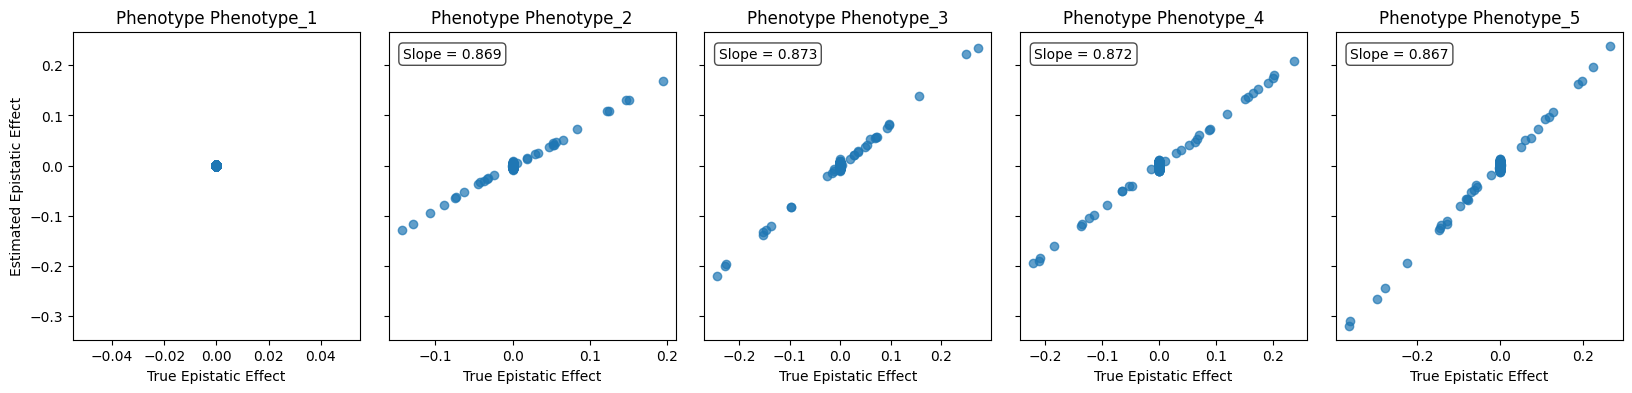

In [181]:
# | code-fold: true

unique_phenotypes = qg_estimates['phenotype'].unique()

# Create a figure with 5 subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=False)
fig.subplots_adjust(wspace=0.1)  # Adjust spacing between plots

# Create a plot for each phenotype
for i, phenotype in enumerate(unique_phenotypes):
    # Filter data for this phenotype
    phenotype_data = qg_estimates[qg_estimates['phenotype'] == phenotype]

    # Create scatter plot on the appropriate subplot
    axes[i].scatter(phenotype_data['true_epi_eff'], phenotype_data['est_epi_eff'],
                   alpha=0.7)

    if phenotype != 'Phenotype_1':
        z = np.polyfit(phenotype_data['true_epi_eff'], phenotype_data['est_epi_eff'], 1)


    # Add title and grid
    axes[i].set_title(f'Phenotype {phenotype}')

    if phenotype != 'Phenotype_1':
        slope = z[0]  # Extract the slope from the polyfit result
        axes[i].text(0.05, 0.95, f'Slope = {slope:.3f}',
                    transform=axes[i].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


    # Only add y-label to the first plot
    if i == 0:
        axes[i].set_ylabel('Estimated Epistatic Effect')

    # Add x-label to all plots
    axes[i].set_xlabel('True Epistatic Effect')


In [187]:
# | code-fold: true

def plot_sample_similarity_matrix(importance_dfs, phenotype_idx=[0], max_samples=50, method='correlation'):
    """
    Plot similarity matrix between samples based on their feature importance patterns.

    Args:
        importance_dfs: List of DataFrames with importance values, one per phenotype
        phenotype_idx: List of indexes of phenotypes to analyze (default: [0] for first phenotype)
        max_samples: Maximum number of samples to include (for visualization clarity)
        method: 'correlation' or 'covariance' for similarity measure

    Returns:
        Tuple containing:
        - List of similarity matrices, one per phenotype
        - List of mean correlation values, one per phenotype (only if method='correlation')
    """
    # Convert single index to list for consistency
    if isinstance(phenotype_idx, int):
        phenotype_idx = [phenotype_idx]

    # Create figure for similarity matrices
    fig_sim, axes_sim = plt.subplots(1, len(phenotype_idx), figsize=(len(phenotype_idx) * 10, 8))
    if len(phenotype_idx) == 1:
        axes_sim = [axes_sim]  # Convert to list for consistent indexing

    # Create figure for correlation histograms if method is correlation
    if method == 'correlation':
        fig_hist, axes_hist = plt.subplots(1, len(phenotype_idx), figsize=(len(phenotype_idx) * 10, 6))
        if len(phenotype_idx) == 1:
            axes_hist = [axes_hist]  # Convert to list for consistent indexing

    # Store similarity matrices and mean correlations
    similarity_matrices = []
    mean_correlations = []

    for i, idx in enumerate(phenotype_idx):
        # Get the dataframe for this phenotype
        if isinstance(importance_dfs, list):
            importance_df = importance_dfs[i]
        else:
            importance_df = importance_dfs[idx]

        # Subset samples if needed
        if importance_df.shape[0] > max_samples:
            # Take a random subset of samples
            sample_indices = np.random.choice(importance_df.shape[0], max_samples, replace=False)
            subset_df = importance_df.iloc[sample_indices]
        else:
            subset_df = importance_df

        # Transpose to get samples as columns
        sample_df = subset_df.T

        # Calculate similarity matrix
        if method == 'correlation':
            similarity_matrix = sample_df.corr()
            title = f'Phenotype {idx+1}: Correlation of Feature Importance Between Samples'
            label = 'Correlation'
            vmin, vmax = -1, 1

            # Calculate mean correlation (from upper triangle, excluding diagonal)
            triu_indices = np.triu_indices_from(similarity_matrix, k=1)
            corr_values = similarity_matrix.values[triu_indices]
            mean_correlation = np.mean(corr_values)
            mean_correlations.append(mean_correlation)

        else:  # covariance
            similarity_matrix = sample_df.cov()
            title = f'Phenotype {idx+1}: Covariance of Feature Importance Between Samples'
            label = 'Covariance'
            # Set vmin/vmax for covariance to have white at zero
            max_abs_val = np.max(np.abs(similarity_matrix.values))
            vmin, vmax = -max_abs_val, max_abs_val

            # Calculate mean correlation (from upper triangle, excluding diagonal)
            triu_indices = np.triu_indices_from(similarity_matrix, k=1)
            corr_values = similarity_matrix.values[triu_indices]
            mean_correlation = np.mean(corr_values)
            mean_correlations.append(mean_correlation)

        # Store the similarity matrix
        similarity_matrices.append(similarity_matrix)

        # Plot heatmap
        im = axes_sim[i].imshow(similarity_matrix, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        fig_sim.colorbar(im, ax=axes_sim[i], label=label)
        axes_sim[i].set_title(title)
        axes_sim[i].set_xlabel('Sample Index')
        axes_sim[i].set_ylabel('Sample Index')

        # Calculate summary statistics for correlation method
        if method == 'correlation':
            # Get upper triangle values (excluding diagonal)
            triu_indices = np.triu_indices_from(similarity_matrix, k=1)
            corr_values = similarity_matrix.values[triu_indices]

            # Plot histogram of correlations
            axes_hist[i].hist(corr_values, bins=30, alpha=0.7, color='steelblue')
            axes_hist[i].axvline(0, color='red', linestyle='--', label="no corr")
            # Add mean correlation line
            axes_hist[i].axvline(mean_correlation, color='green', linestyle='-',
                                label=f"mean corr: {mean_correlation:.4f}")
            axes_hist[i].set_xlabel('Correlation Value')
            axes_hist[i].set_ylabel('Frequency')
            axes_hist[i].set_title(f'Phenotype {idx+1}: Distribution of Sample-to-Sample Correlations')
            axes_hist[i].legend()

    # Adjust layout for all plots
    fig_sim.tight_layout()
    if method == 'correlation':
        fig_hist.tight_layout()

    plt.show()

    if method == 'correlation':
        return similarity_matrices, mean_correlations
    else:
        return similarity_matrices, mean_correlations

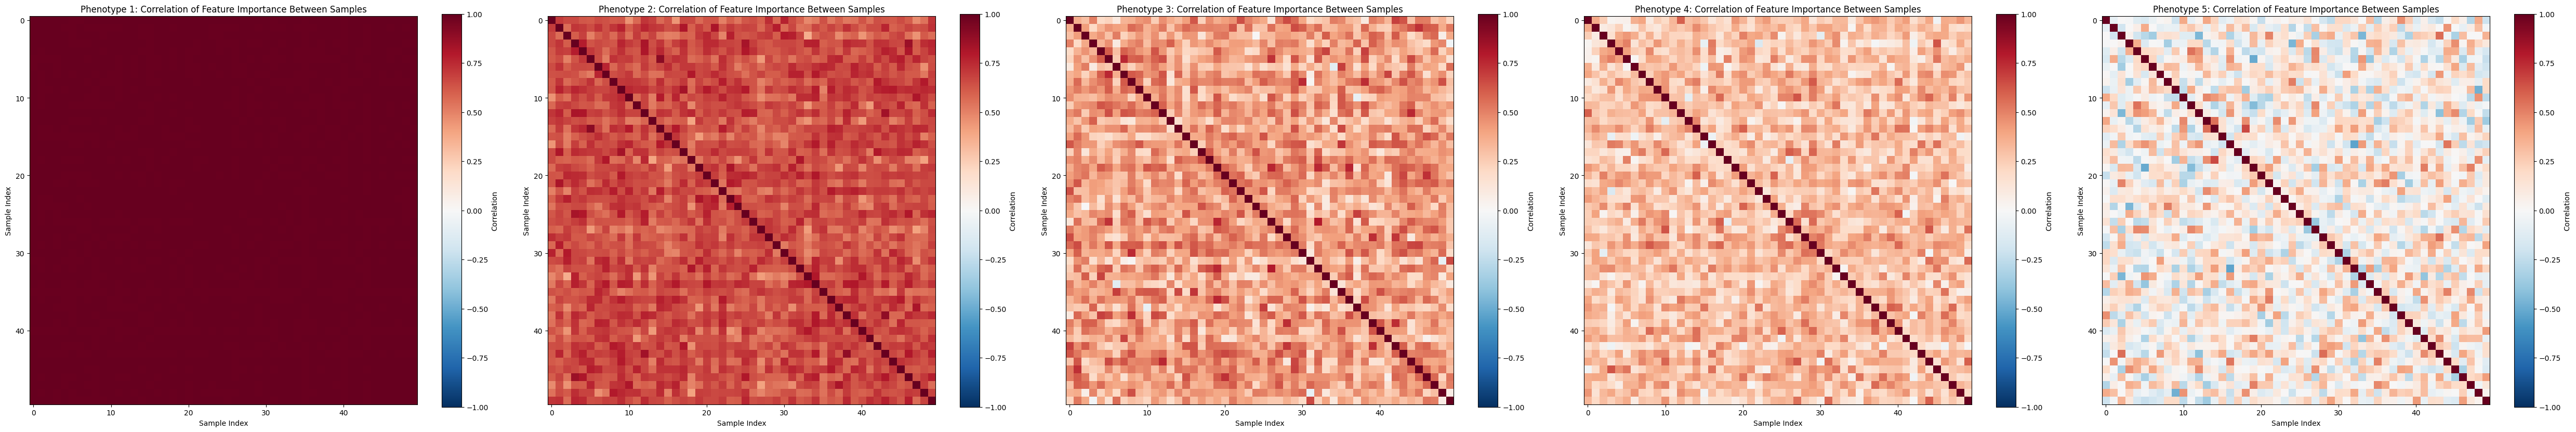

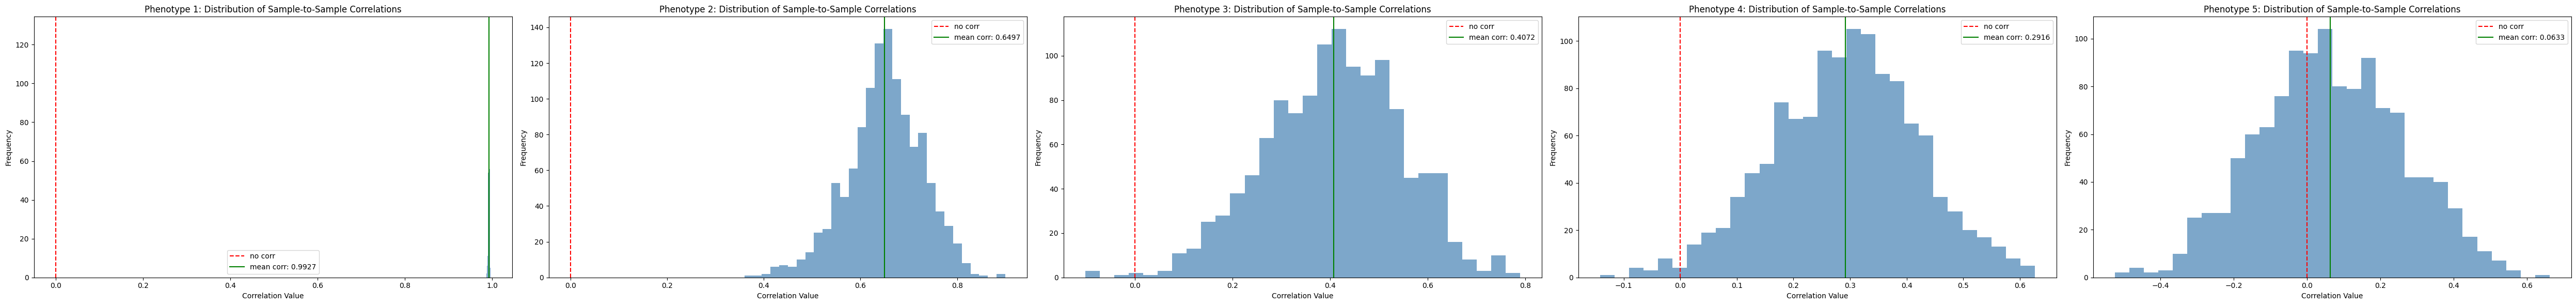

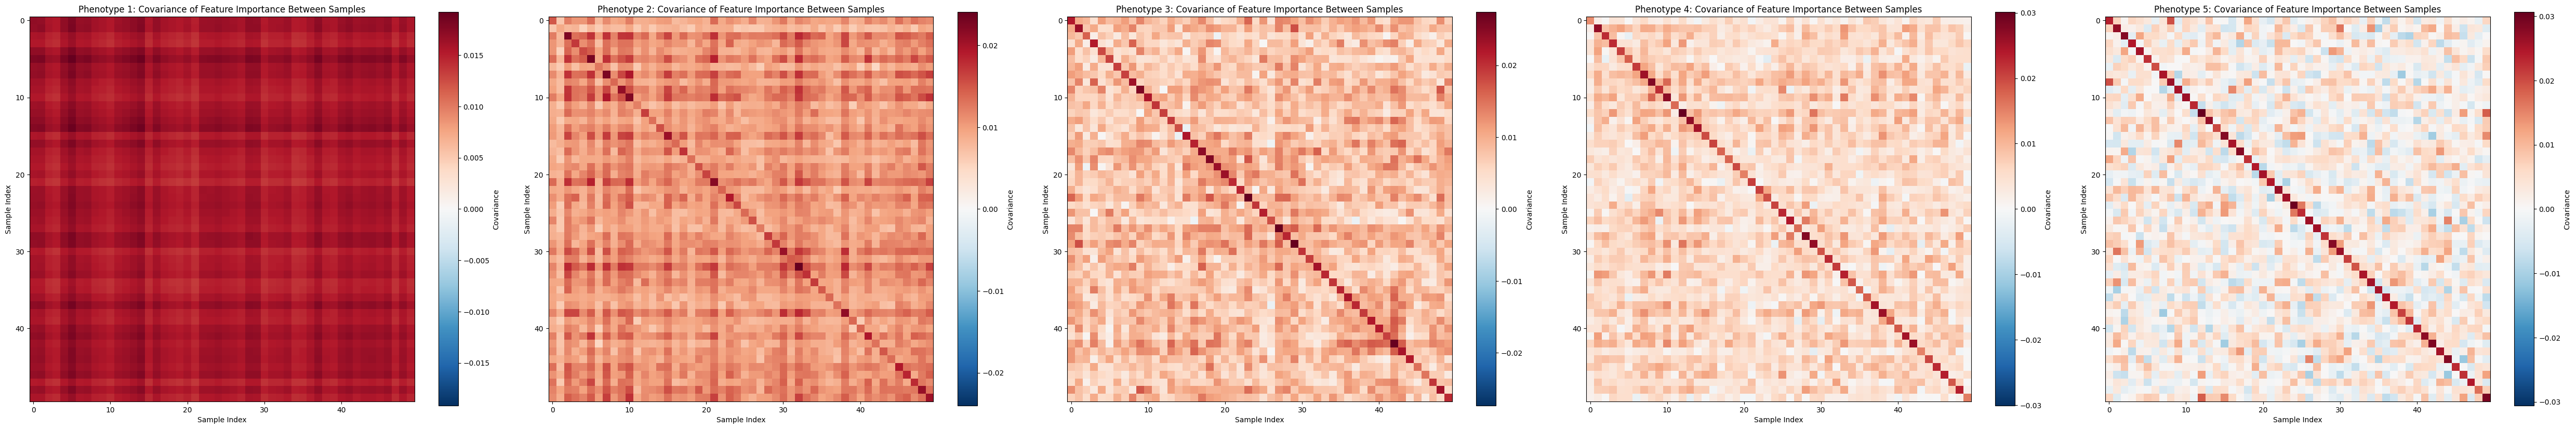

In [188]:
similarity_matrices, mean_correlations = plot_sample_similarity_matrix(
     importance_results,
     phenotype_idx=[0, 1, 2, 3, 4],
     max_samples=50,  # Adjust as needed
     method='correlation'  # 'covariance' or 'correlation'
 )
_, mean_covariances = plot_sample_similarity_matrix(
     importance_results,
     phenotype_idx=[0, 1, 2, 3, 4],
     max_samples=50,  # Adjust as needed
     method='covariance'  # 'covariance' or 'correlation'
 )

## Appendix on estimating variance components


In [189]:
mean_correlations
mean_covariances = [item * n_loci for item in mean_covariances]

In [190]:
results_df_fit

,trait,trait_index,pearson_correlation,r2,relAA,VAA_base,VA_base,H2_captured,VAA_captured
0,Trait1,1,0.998755,0.997495,1.000,0.000,1.000,0.997495,-inf
1,Trait2,2,0.994266,0.988353,0.787,0.213,0.787,0.988353,0.945317
2,Trait3,3,0.991080,0.981570,0.505,0.495,0.505,0.981570,0.962768
3,Trait4,4,0.988457,0.975273,0.403,0.597,0.403,0.975273,0.958581
4,Trait5,5,0.986909,0.969618,0.122,0.878,0.122,0.969618,0.965397


In [191]:
def calculate_va(importance_dfs):
    va_list = []

    for i, df in enumerate(importance_dfs):
        # Calculate mean sensitivity for each locus
        locus_means = df.mean(axis=0)

        # Calculate variance of these means
        variance_of_means = np.var(locus_means)

        # Scale by number of loci and convert to additive variance
        L = len(locus_means)
        va = variance_of_means * L

        va_list.append(va)
        print(f"Phenotype {i+1}: VA = {va:.6f}")

    return va_list

In [192]:
additive_vars = calculate_va(importance_results)

Phenotype 1: VA = 0.969316
Phenotype 2: VA = 0.705949
Phenotype 3: VA = 0.514928
Phenotype 4: VA = 0.403304
Phenotype 5: VA = 0.118918


Two ways of estimating additive variance:

 * Covariance in sensitivity values across pairs of samples
 * Variance of mean sensitivity values * #loci
  
Both provide reasonably close estimates of ground truth Va (comparing to ground truth relAA since Vg = 1 in the sims)

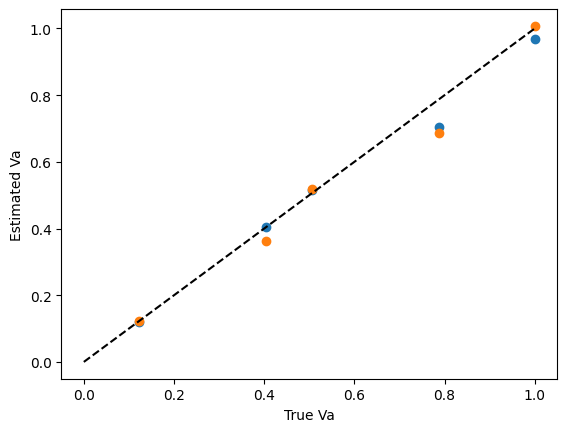

In [193]:
plt.scatter(results_df_fit['relAA'],additive_vars)
plt.scatter(results_df_fit['relAA'],mean_covariances)
plt.xlabel('True Va')
plt.ylabel('Estimated Va')
plt.plot([0, 1], 'k--', label='1:1 Line')


But if we compare the correlation in sensitivity values to relAA we find that the correlation underestimates Va/Vg implying that the denominator is inflated.

We can test this explicitly by calculating the mean variance in sensitivity values *within* sample since this will correspond to Vg

In [194]:
def calculate_individual_sensitivity_variance(importance_dfs):
    mean_variance_list = []

    for i, df in enumerate(importance_dfs):
        # Calculate variance across loci for each individual
        # Each row is an individual, each column is a locus
        individual_variances = df.var(axis=1)

        # Calculate mean of these variances across individuals
        mean_variance = individual_variances.mean()
        mean_variance = mean_variance * n_loci
        mean_variance_list.append(mean_variance)
        print(f"Phenotype {i+1}: Mean individual sensitivity variance = {mean_variance:.6f}")

    return mean_variance_list

In [195]:
G_vars  = calculate_individual_sensitivity_variance(importance_results)

Phenotype 1: Mean individual sensitivity variance = 0.993854
Phenotype 2: Mean individual sensitivity variance = 1.097725
Phenotype 3: Mean individual sensitivity variance = 1.351881
Phenotype 4: Mean individual sensitivity variance = 1.403063
Phenotype 5: Mean individual sensitivity variance = 1.571829


Text(0, 0.5, 'Freq')

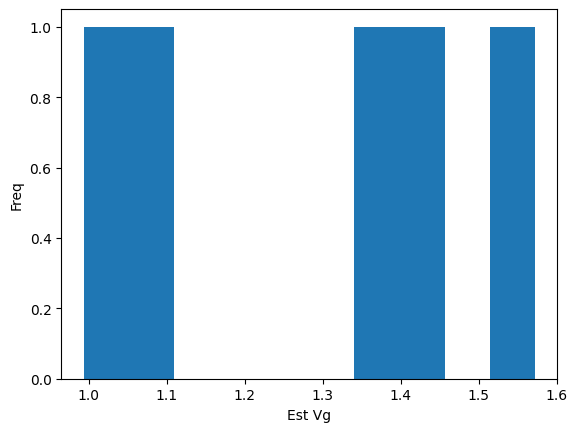

In [210]:
plt.hist(G_vars)
plt.xlabel('Est Vg')
plt.ylabel('Freq')

Ground truth Vg is 1 (under H2 of 1), so it seems that the more epistasis is present in the simulation, the more inflated total epistatic variance


So what is causing this inflation of Vg?

We know Va is estimates fairly well with 2 methods. What about Vi?


One way we can estimate Vi is by looking at the variance in epistatic effects estimated from all pairs of loci. 


This will capture both true positive pairwise interactions and false positive ones that contribute to noise.


In [197]:
def calculate_epistatic_variance_with_distribution(results_df):
    ve_list = []
    variance_components = {}

    for pheno_idx, group in results_df.groupby('phenotype_idx'):
        # Calculate total number of loci pairs
        n_pairs = len(group)
        #Variance of effects × n_pairs
        v_e_variance = np.var(group['est_epi_eff']) * n_pairs
        ve_list.append(v_e_variance)

        print(f"Phenotype {pheno_idx}: VE (variance × n_pairs): {v_e_variance:.6f}")

    return ve_list, variance_components

In [198]:
ve_variance, _ = calculate_epistatic_variance_with_distribution(qg_estimates)


Phenotype 1: VE (variance × n_pairs): 0.000645
Phenotype 2: VE (variance × n_pairs): 0.172460
Phenotype 3: VE (variance × n_pairs): 0.383168
Phenotype 4: VE (variance × n_pairs): 0.461989
Phenotype 5: VE (variance × n_pairs): 0.681336


Again we find a modest underestimate of Vi, particularly as epistasis grows.

This isn't necessarily super surprising as we know that pairwise effects are regularized more heavily than additive ones from previous analyses

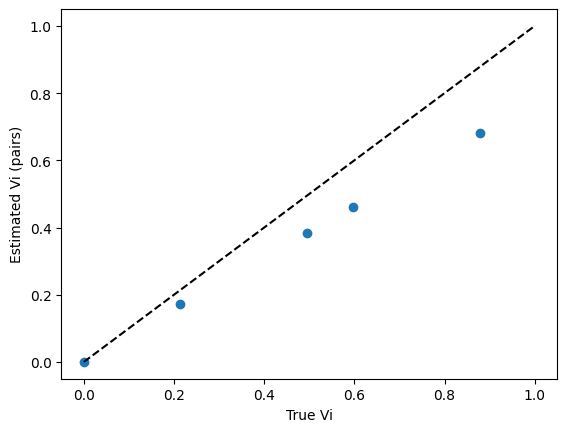

In [202]:
plt.scatter(1-results_df_fit['relAA'],ve_variance)
plt.xlabel('True Vi')
plt.ylabel('Estimated Vi (pairs)')
plt.plot([0, 1], 'k--', label='1:1 Line')


In sum we have two methods for estimating relAA (Va/Vg).

* Either restrict to pairwise epistasis, compare to Va
* Or calculating the correlation in sensitivites which captures all of Vg but inflates it if epistasis is strong

Text(0, 0.5, 'jacobian vars')

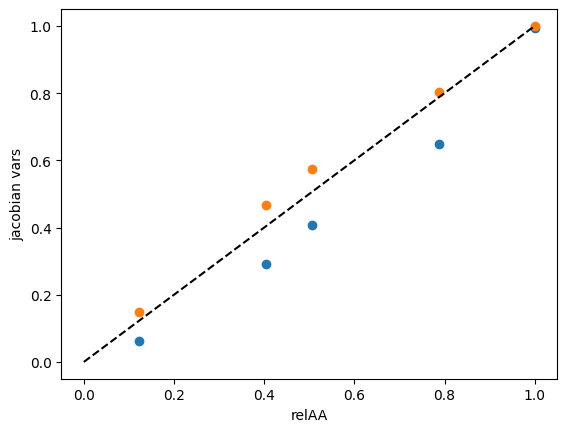

In [211]:
relAA_est_pairs = [va /(va+ vg) for va, vg in zip(additive_vars, ve_variance)]

plt.scatter(results_df_fit['relAA'],mean_correlations )
plt.scatter(results_df_fit['relAA'],relAA_est_pairs )

plt.plot([0, 1], 'k--', label='1:1 Line')
plt.xlabel('relAA')
plt.ylabel('jacobian vars')

## Heritability effects

What happens if we add environmental noise to our phenotypes (i.e. drop H2 below 1)?


Start to see noise and increasing regularization creep into the results. But overall the model is suprisingly robust to noise. 

In [225]:
new_heritability = 0.25

loaders = create_data_loaders_with_heritability(base_file_name, heritability=new_heritability)  # choose heritability
train_loader_gp = loaders['train_loader_gp']
test_loader_gp = loaders['test_loader_gp']

In [226]:
#Run MLP training
model_H05 = GP_net(
    n_loci=n_loci,
    hidden_layer_size=hidden_size,
    n_pheno=n_phen
    )

# Use early stopping with appropriate patience
model_H05, best_loss_gp = train_gpnet(model=model,
                                    train_loader=train_loader_gp,
                                    test_loader=test_loader_gp,
                                    n_loci=n_loci,
                                    learning_rate=learning_rate,
                                    device=device)
model_H05.eval()

Epoch: 10/100, Train Loss: 0.532572, Test Loss: 0.751912
Early stopping triggered after 11 epochs
Restoring best model from epoch 1


GP_net(
  (layer1): Linear(in_features=64, out_features=1024, bias=False)
  (layer2): Linear(in_features=1024, out_features=1024, bias=False)
  (layer3): Linear(in_features=1024, out_features=5, bias=False)
)

In [227]:
# | code-fold: true
# | code-summary: "model performance results"

true_phenotypes = []
predicted_phenotypes = []

with torch.no_grad():
    for phens, gens in test_loader_gp:
        phens = phens.to(device)
        gens = gens.to(device)
        gens_simplified = gens[:, 1::2]

        # Get predictions
        predictions = model_H05(gens_simplified)

        # Store results
        true_phenotypes.append(phens.cpu().numpy())
        predicted_phenotypes.append(predictions.cpu().numpy())

    # Concatenate batches
    true_phenotypes = np.concatenate(true_phenotypes)
    predicted_phenotypes = np.concatenate(predicted_phenotypes)

    # Calculate correlations for each phenotype
    correlations = []
    r2s = []

    for i in range(n_phen):
        corr, _ = pearsonr(true_phenotypes[:, i], predicted_phenotypes[:, i])
        correlations.append(corr)

        r2 = r2_score(true_phenotypes[:, i], predicted_phenotypes[:, i])
        r2s.append(r2)

    true_h2 = [1, 0.787, 0.505, 0.403, 0.122]

    # Create a detailed DataFrame with all results
    results_df_fit = pd.DataFrame({
        'trait': phenotype_names,
        'trait_index': range(1, n_phen + 1),
        'pearson_correlation': correlations,
        'r2': r2s,
        'relAA': true_h2
    })

In [228]:
results_df_fit['VAA_base'] =      (1 - results_df_fit['relAA'])* new_heritability

results_df_fit['VA_base'] =     (results_df_fit['relAA'])* new_heritability



results_df_fit['H2_captured'] = results_df_fit['r2']/new_heritability

results_df_fit['VAA_captured'] =    (results_df_fit['r2'] - results_df_fit['VA_base'] )/ results_df_fit['VAA_base']


results_df_fit.head()

results_df_fit

,trait,trait_index,pearson_correlation,r2,relAA,VAA_base,VA_base,H2_captured,VAA_captured
0,Trait1,1,0.471561,0.220756,1.000,0.00000,0.25000,0.883023,-inf
1,Trait2,2,0.462375,0.192740,0.787,0.05325,0.19675,0.770958,-0.075313
2,Trait3,3,0.415267,0.168019,0.505,0.12375,0.12625,0.672074,0.337524
3,Trait4,4,0.390577,0.150238,0.403,0.14925,0.10075,0.600953,0.331579
4,Trait5,5,0.356429,0.111363,0.122,0.21950,0.03050,0.445453,0.368398


Processed 1000 samples
Completed importance analysis for 1500 samples


<Figure size 7500x700 with 0 Axes>

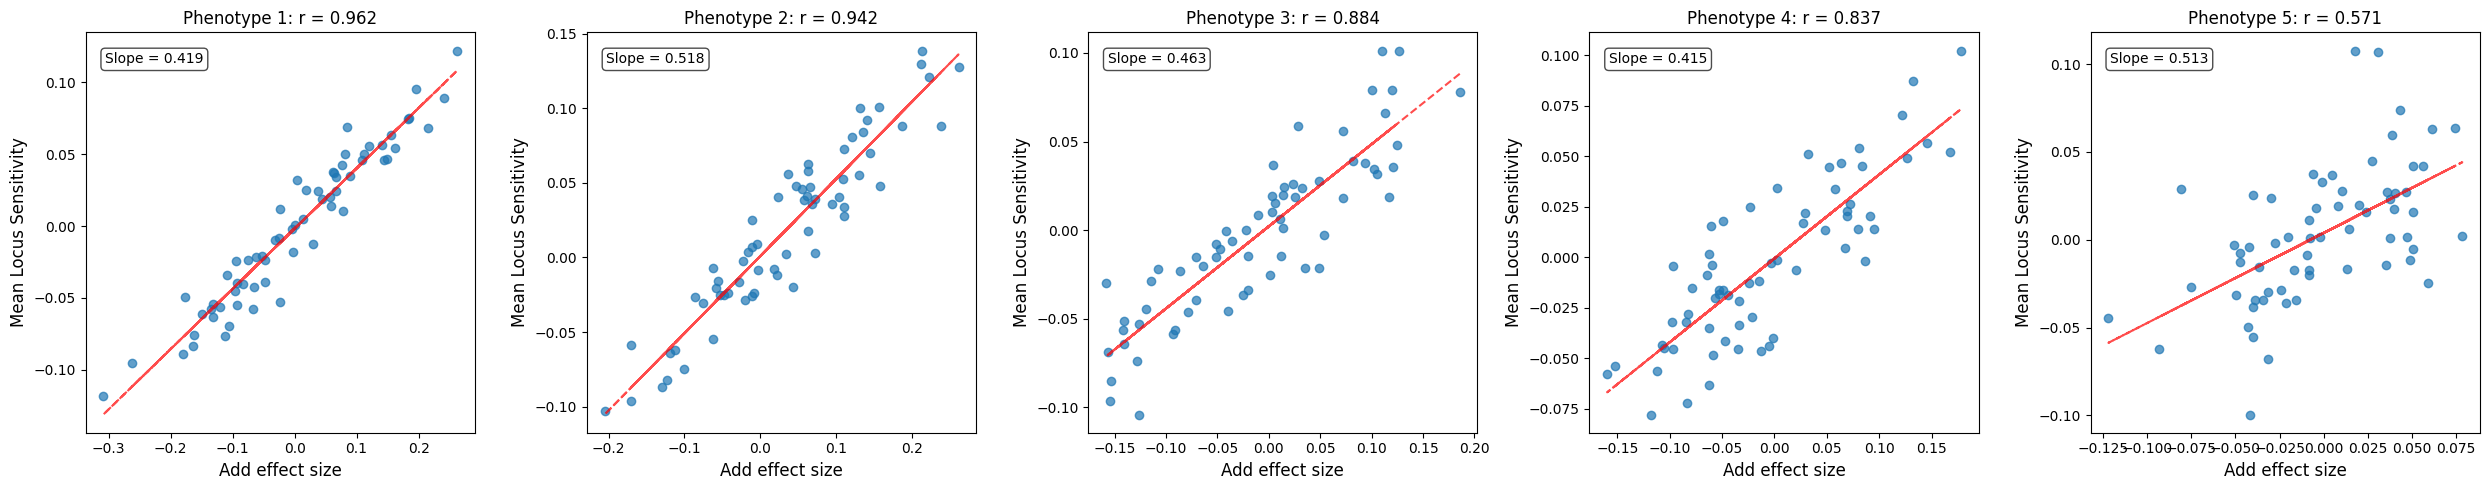

In [229]:
# Usage example:
importance_results = analyze_feature_importance_across_validation(
    model=model_H05,
    validation_loader=test_loader_gp,
    true_effects_df=true_eff,
    phenotype_idx=[0,1,2,3,4],  #  phenotype
    device=device,
    max_samples=2000  # Limit number of samples for faster processing
)

/Users/georgy/miniconda3/envs/gpmap/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


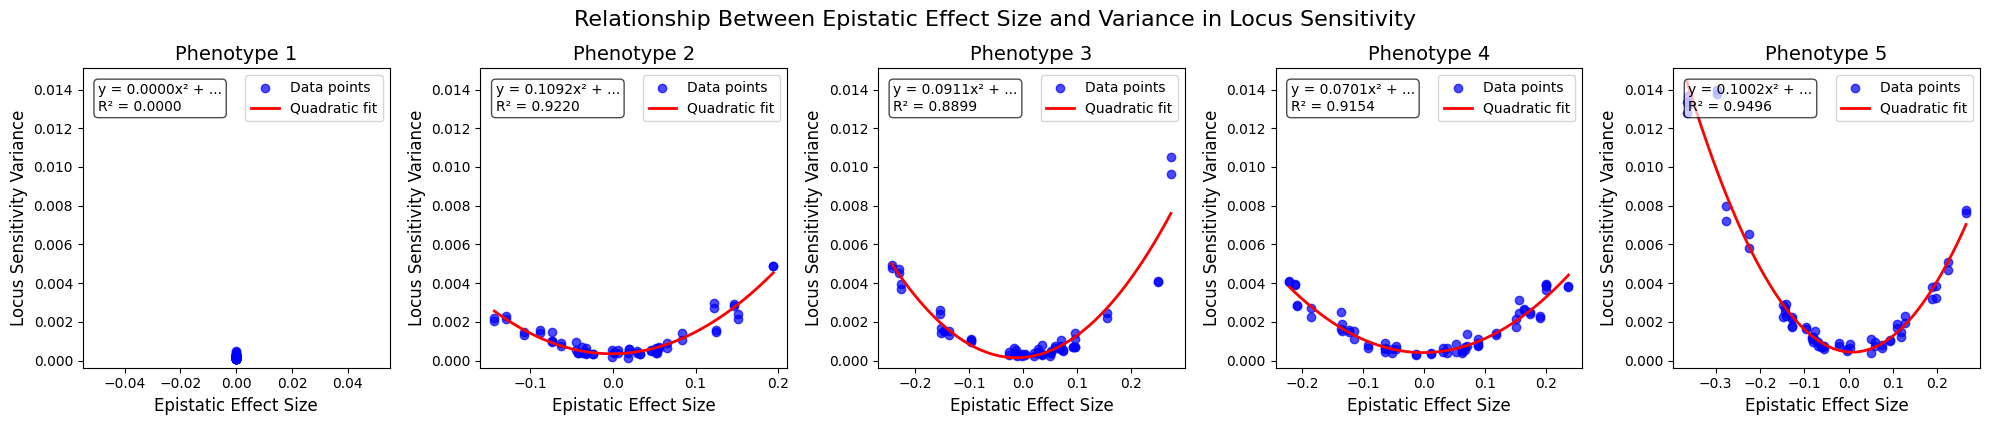

In [230]:
plot_sensitivity_variance_vs_epistasis(importance_results, true_eff, phenotype_idx=[0, 1, 2, 3 ,4])

In [234]:
#calculate genotype specific sensitivity means for all possible pairs of loci
paired_all = extract_all_epistatic_pairs(model_H05, test_loader_gp, true_eff,
                               phenotype_idx=[1,2,3,4,5], device=device,
                               max_samples=2000)

Analyzing phenotypes: [1, 2, 3, 4, 5]
Generated 2016 total locus pairs for phenotype 1, 0 with known epistatic effects
Generated 2016 total locus pairs for phenotype 2, 32 with known epistatic effects
Generated 2016 total locus pairs for phenotype 3, 32 with known epistatic effects
Generated 2016 total locus pairs for phenotype 4, 32 with known epistatic effects
Generated 2016 total locus pairs for phenotype 5, 32 with known epistatic effects
Processed 1000 samples
Completed analysis for 1500 samples


/var/folders/g0/035wvz950sb5mbrttg9wtgy40000gn/T/ipykernel_55672/472537500.py:314: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_means = summary_df.groupby('pair_id').apply(


In [235]:
#estimate quant-gen parameters
qg_estimates = estimate_effects_from_sensitivities(paired_all, heritability=heritability)
qg_estimates.head()

Using heritability scaling factor: 1.0000 (h² = 1.00)
Detected genotype encoding: -1/1


,phenotype,phenotype_idx,locus1,locus2,pair_id,true_add_eff1,true_add_eff2,true_epi_eff,scaled_true_add_eff1,scaled_true_add_eff2,...,est_add_eff1,est_add_eff2,est_epi_eff,epi_est1,epi_est2,est_epi_from_var,var_sens1,var_sens2,heritability,encoding_type
0,Phenotype_1,1,1,2,1_1_2,-0.025711,0.044239,0.0,-0.025711,0.044239,...,-0.004158,0.009481,0.000021,-0.000188,0.000231,-0.000786,0.000003,2.316325e-06,1,-1/1
1,Phenotype_1,1,1,3,1_1_3,-0.025711,-0.120390,0.0,-0.025711,-0.120390,...,-0.004174,-0.028215,-0.001276,-0.001415,-0.001137,-0.001062,0.000005,4.233008e-06,1,-1/1
2,Phenotype_1,1,1,4,1_1_4,-0.025711,-0.067198,0.0,-0.025711,-0.067198,...,-0.004158,-0.028714,-0.000351,-0.000386,-0.000316,-0.000663,0.000003,1.021250e-06,1,-1/1
3,Phenotype_1,1,1,5,1_1_5,-0.025711,0.000775,0.0,-0.025711,0.000775,...,-0.004183,0.000239,0.002210,0.002050,0.002369,0.001321,0.000007,6.972834e-06,1,-1/1
4,Phenotype_1,1,1,6,1_1_6,-0.025711,0.030328,0.0,-0.025711,0.030328,...,-0.004152,-0.006273,-0.000210,-0.000022,-0.000398,-0.000537,0.000003,3.104590e-07,1,-1/1


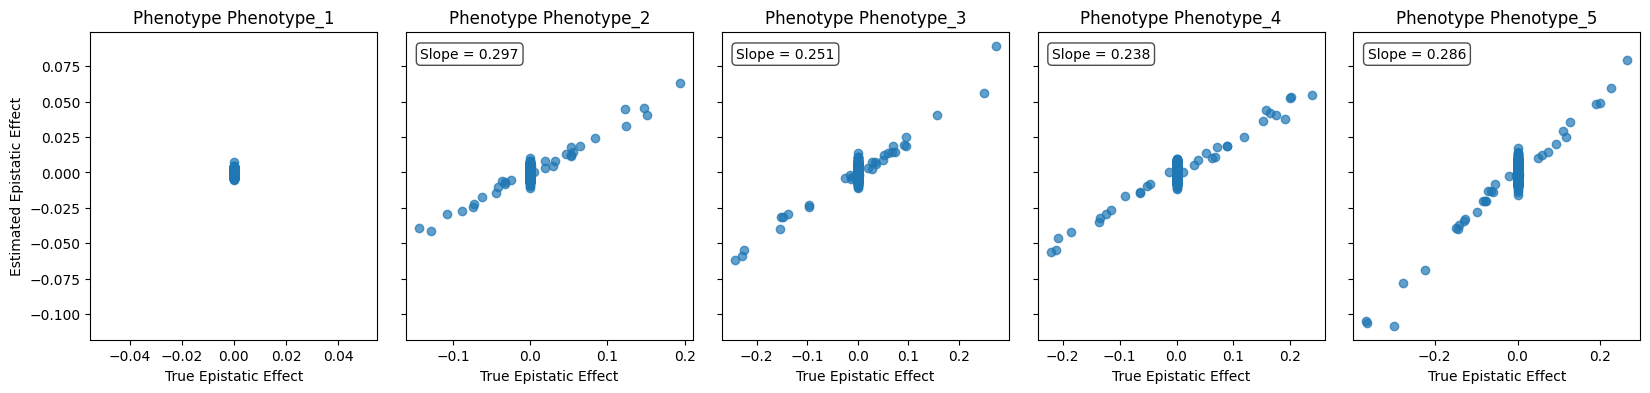

In [236]:
# | code-fold: true

unique_phenotypes = qg_estimates['phenotype'].unique()

# Create a figure with 5 subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True, sharex=False)
fig.subplots_adjust(wspace=0.1)  # Adjust spacing between plots

# Create a plot for each phenotype
for i, phenotype in enumerate(unique_phenotypes):
    # Filter data for this phenotype
    phenotype_data = qg_estimates[qg_estimates['phenotype'] == phenotype]

    # Create scatter plot on the appropriate subplot
    axes[i].scatter(phenotype_data['true_epi_eff'], phenotype_data['est_epi_eff'],
                   alpha=0.7)

    if phenotype != 'Phenotype_1':
        z = np.polyfit(phenotype_data['true_epi_eff'], phenotype_data['est_epi_eff'], 1)


    # Add title and grid
    axes[i].set_title(f'Phenotype {phenotype}')

    if phenotype != 'Phenotype_1':
        slope = z[0]  # Extract the slope from the polyfit result
        axes[i].text(0.05, 0.95, f'Slope = {slope:.3f}',
                    transform=axes[i].transAxes,
                    verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


    # Only add y-label to the first plot
    if i == 0:
        axes[i].set_ylabel('Estimated Epistatic Effect')

    # Add x-label to all plots
    axes[i].set_xlabel('True Epistatic Effect')
